# Bayesian Regression

<br>

***

<br>

## Import Libraries

In [2]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as at
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import patsy
from datetime import timedelta, datetime
from scipy import stats

print(f"PYMC Version {pm.__version__}")

PYMC Version 5.15.0


<br>

***

<Br>

## Continuous Target Model

- Model: Predicting Median Housing Income
- Dataset: California Housing

In [2]:
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing(as_frame=True)
df = df.frame
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

In [3]:
df.shape

(20640, 9)

In [4]:
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [5]:
df['MedHouseVal'].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

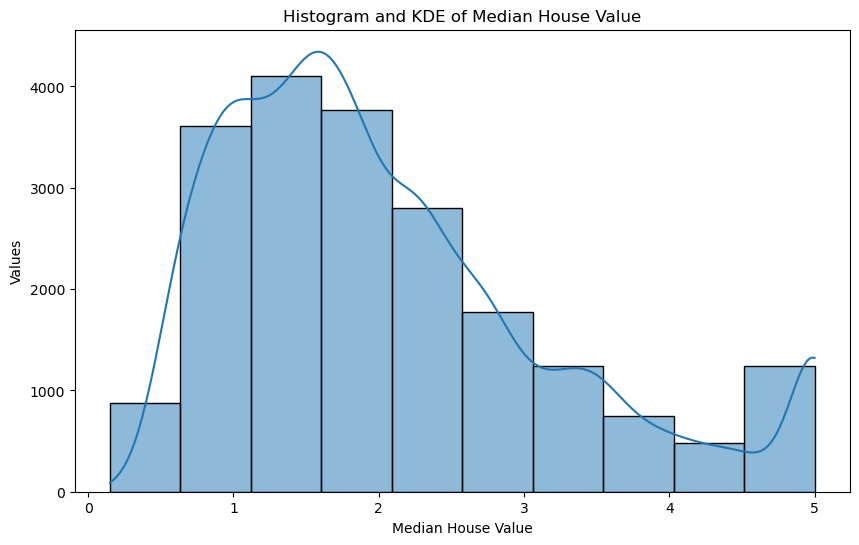

In [6]:
# Histogram & KDE plot of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], kde=True, bins=10)
plt.title('Histogram and KDE of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Values')
plt.show()

In [7]:
# ==================================================== #
# Optional to Standardize Variables                    #
# ==================================================== #

# pros: sampling efficiency (NUTS), numerical stability (MCMC), you can transform back to normal at the end (or not - interpret the standard deviation)
# I saw it go from 48 seconds to 16 seconds
# x_norm = (x - x.mean()) / x.std()

# Find Features
X = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y = df['MedHouseVal']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()

# Convert scaled features to tensors
X_shared = pm.floatX(X_scaled)
y_shared = pm.floatX(y_scaled)

In [8]:
%%time
# Naming your pm.Model and opening it up in the context editor to add and change parameters - could code this up differently but not recommended
with pm.Model() as bayesian_model:
    
    # priors
    # mu - the location or center or mean of your data - if you think your coef is + then make it positive, otherwise you can make it negative
    # sigma - the standard deviation or spread of your data - a large sd would indicate strong confidence in your prior, whereas a small sd indicates uncertainty
    # examples: mu=2, sigma=1, strong priors; mu=1 sigma=10, weak priors; mu=0, sigma=100, uninformative priors
    # Use priors to input domain knowledge, regularlization to avoid overfitting, and make small data more robus
    
    # intercept: represents the predicted value of the dependent variable when all independent variables are equal to zero
    # mu is 0 because we do not have a prior about the intercept
    # sigma is 10 because we have lots of uncertainty about the prior
    # the first variable is the python name which can be used to reference the variable
    # the second variable in quotes is PYMC variable name which is a label you'll see in your plots

    # Priors for intercept
    intercept = pm.Normal('Intercept', mu=0, sigma=1)

    # Betas - even if you have features that are binary, you model them all with normal distributions
    # This is because it's the variable that is binary, not the coefficient

    # Priors for each feature based on domain knowledge
    beta_medinc = pm.Normal("beta_medinc", mu=1, sigma=0.5)     # Expecting a positive influence
    beta_houseage = pm.Normal("beta_houseage", mu=0.5, sigma=0.5)  # Moderate positive effect
    beta_averagerooms = pm.Normal("beta_averagerooms", mu=1, sigma=0.5)  # Positive effect
    beta_aveoccup = pm.Normal("beta_aveoccup", mu=0, sigma=1)    # Neutral or negative effect
    beta_latitude = pm.Normal("beta_latitude", mu=0, sigma=1)    # Weak prior, location-specific
    beta_longitude = pm.Normal("beta_longitude", mu=0, sigma=1)  # Weak prior, location-specific

    # Another way of doing this if you have a lot of features
    # beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1] - 1)
    # logits = intercept + pm.math.dot(X.iloc[:, 1:], beta)
        # or this...
    # import pytensor.tensor as at
    # july_cpm_cert_drops = pm.Model(coords={"predictors": columns}) # outside of the pm.Model() context
    # beta = pm.Normal("beta", 0, 10, dims="predictors")
    # beta0 = pm.Normal("beta0", 0, 10)
    # mu = beta0 + at.dot(X_train, beta)

    # ==================================================== #
    # Logistic Likelihood                                  #
    # ==================================================== #

    # Regression Formula
    mu = (intercept 
          + beta_medinc * X_shared[:, 0] 
          + beta_houseage * X_shared[:, 1] 
          + beta_averagerooms * X_shared[:, 2] 
          + beta_aveoccup * X_shared[:, 3] 
          + beta_latitude * X_shared[:, 4] 
          + beta_longitude * X_shared[:, 5])

    # ==================================================== #
    # MCMC NUTS Process                                    #
    # ==================================================== #
    
    # Magic Inference Button
    # 2000 samples from the posterior distribution (2000-5000 is good, closer to 100000 is great)
    # More is better - the samples build up over time as it explores the space - only negative is time and resources
    # Increase when you have a complex model or want precision
    # Decrease when you don't have time or are prototyping
    # trace = pm.sample(4000, return_inferencedata=True)

    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_shared)

    # sampling
    # -> 2000 Draws - 2000 is good, more is better, 5000 to 10000 is solid
    # -> 4 Chains - Ensure convergence & increase sampling diversity, improves stability
    # -> 1000 Tuning Steps - These will tune the sampler before your actual samples are taken
    # -> 0.9 Target Acceptance Rate - Recommended 0.8 to 0.95, higher is more accurate and stable, but slower

    # Inference Object
    trace = pm.sample(2000, chains=4, tune=1000, target_accept=0.9)
    # 1. Diagnostics for convergence -> they should overlap in the trace plots
    # 2. Avoiding local minima -> The chains are exploring a posterior space and can get caught in local regions of space
    # 3. Poor mixing happens when MCMC struggles to move across parameter space, multiple chains helps here
    # 4. Improves effectiveness of small sample sizes, improves autocorrelation and improves quality of inferences
    # Use for complex models, diagnositcs, uncertain priors, multi-modal posteriors


# After sampling, you can convert the coefficients back to the original scale:
# If needed, you can back-transform them for interpretability.
# beta_var1_original = trace['beta_var1'].mean() * x['var1'].std()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_medinc, beta_houseage, beta_averagerooms, beta_aveoccup, beta_latitude, beta_longitude, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 114 seconds.


CPU times: total: 9.25 s
Wall time: 2min 4s


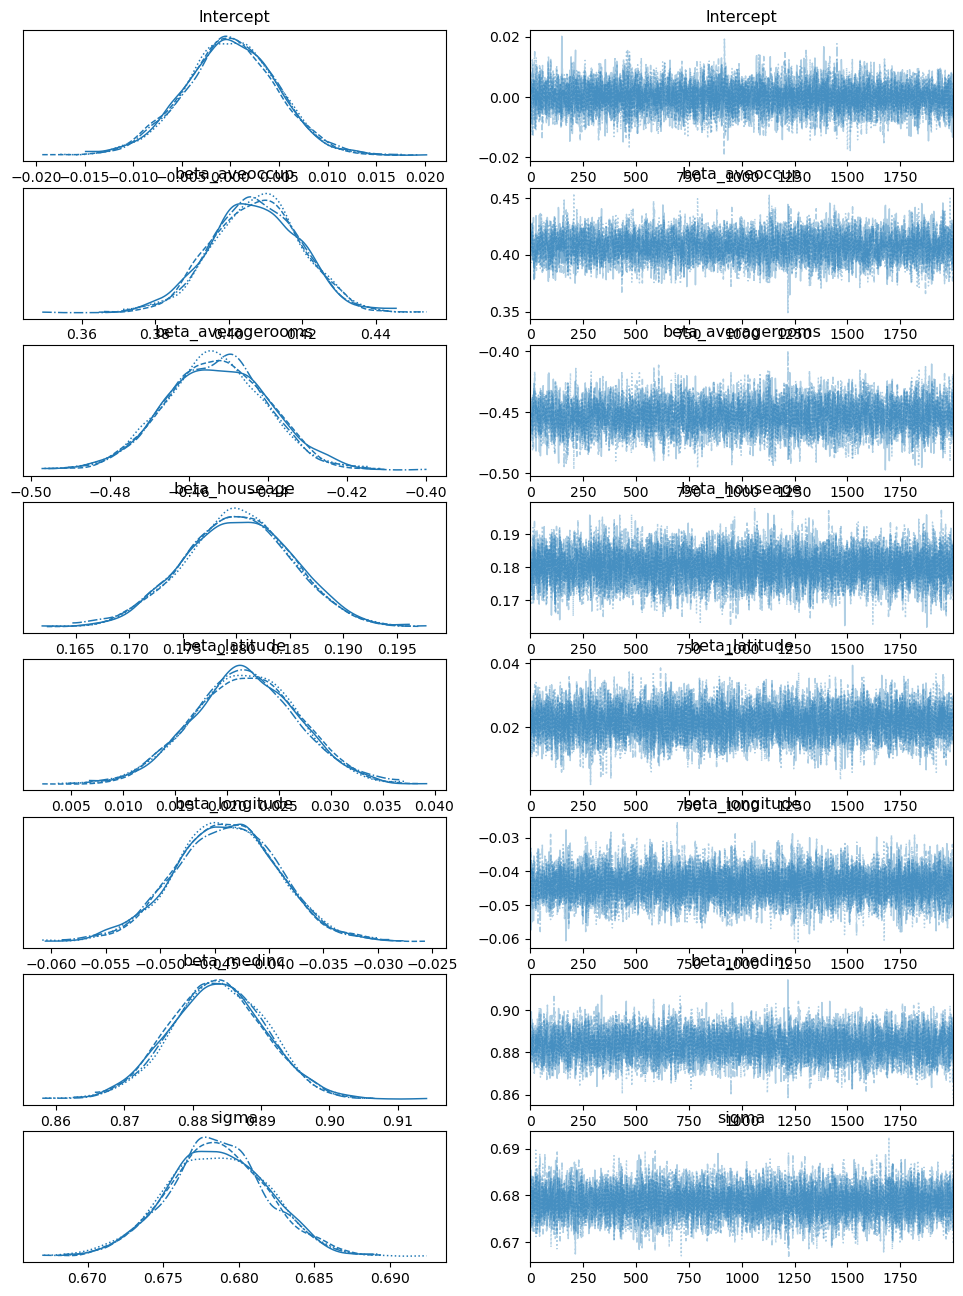

In [9]:
# ==================================================== #
# Visualize Model Results & Diagnostics                #
# ==================================================== #

# Visualize Trace which gives us posterior distributions for the intercept and each beta coefficient

# Left #
#------#
# Posterior distribution plots show the range of values for each coefficient which can help us understand the uncertainty around the causal effect of the variable
# You want to see a normal distribution bell curve - shows the model converged properly; Skewed or multimodal is no good
# Wider distributions shows more uncertainty (narrow=more certainty, but they can be too narrow...)

# Right #
#-------#
# Trace plots: value of sampled parameter at each step of the MCMC process - look for a fuzzy catapillar
# After the inital "burn-in" period, it should look noisy but stable horizontal band - meaning it converged & is exploring the posterior distribution effectively
# It should not show any drift, it should be on the line of the mean
# It should also show good mixing of different values
# Sometimes you disgard the early samples that are part of that burn-in period (person does this, so ask him)

# Signals #
#---------#
# Trace plots that are sticky or deviating off the mean
# Trace plots with multiple chains that don't overlap
# Trade plots that are multi-modal
# Too wide or too narrow posterior distributions

# Diagnostics #
#-------------#
# Gelman-Rubin Stat (R-hat) -> check if chains have converged, < 1.1 means chains have converged
# Effective Sample Size -> How many ind samples the MCMC algorithm has drawn, if ESS is smaller than totla samples, then poor mixing
# Check for autocorrelation of MCMC samples
# Trace plots for multiple chains -> set chains=4 on the pm.sample function & check if the chains overlap for good convergence

az.plot_trace(trace);
# plt.show();
# while this may not look fantastic...google what a bad one looks like and you'll see this is perfectly a-okay

In [10]:
# ==================================================== #
# Summarize Model Results                              #
# ==================================================== #
# Summary of the posterior distributions
# The 95% HDI shows where the bulk of the poterior mass lies
az.summary(trace, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept          0.000  0.005    -0.009      0.009        0.0      0.0   
beta_aveoccup      0.408  0.012     0.384      0.430        0.0      0.0   
beta_averagerooms -0.453  0.013    -0.479     -0.429        0.0      0.0   
beta_houseage      0.180  0.005     0.170      0.190        0.0      0.0   
beta_latitude      0.022  0.005     0.012      0.032        0.0      0.0   
beta_longitude    -0.044  0.005    -0.053     -0.035        0.0      0.0   
beta_medinc        0.884  0.007     0.870      0.897        0.0      0.0   
sigma              0.679  0.003     0.672      0.685        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            9102.0    5442.0    1.0  
beta_aveoccup        4969.0    5027.0    1.0  
beta_averagerooms    4966.0    5347.0    1.0  
beta_houseage        8993.0    6051.0    1.0  
beta_latitude        9009.0    6004.0    1.0  
beta_longitude       9585.0    5370.0    1.0  
beta_medinc          5508.0    5781.0    1.0  
sigma                9442.0    5320.0    1.0

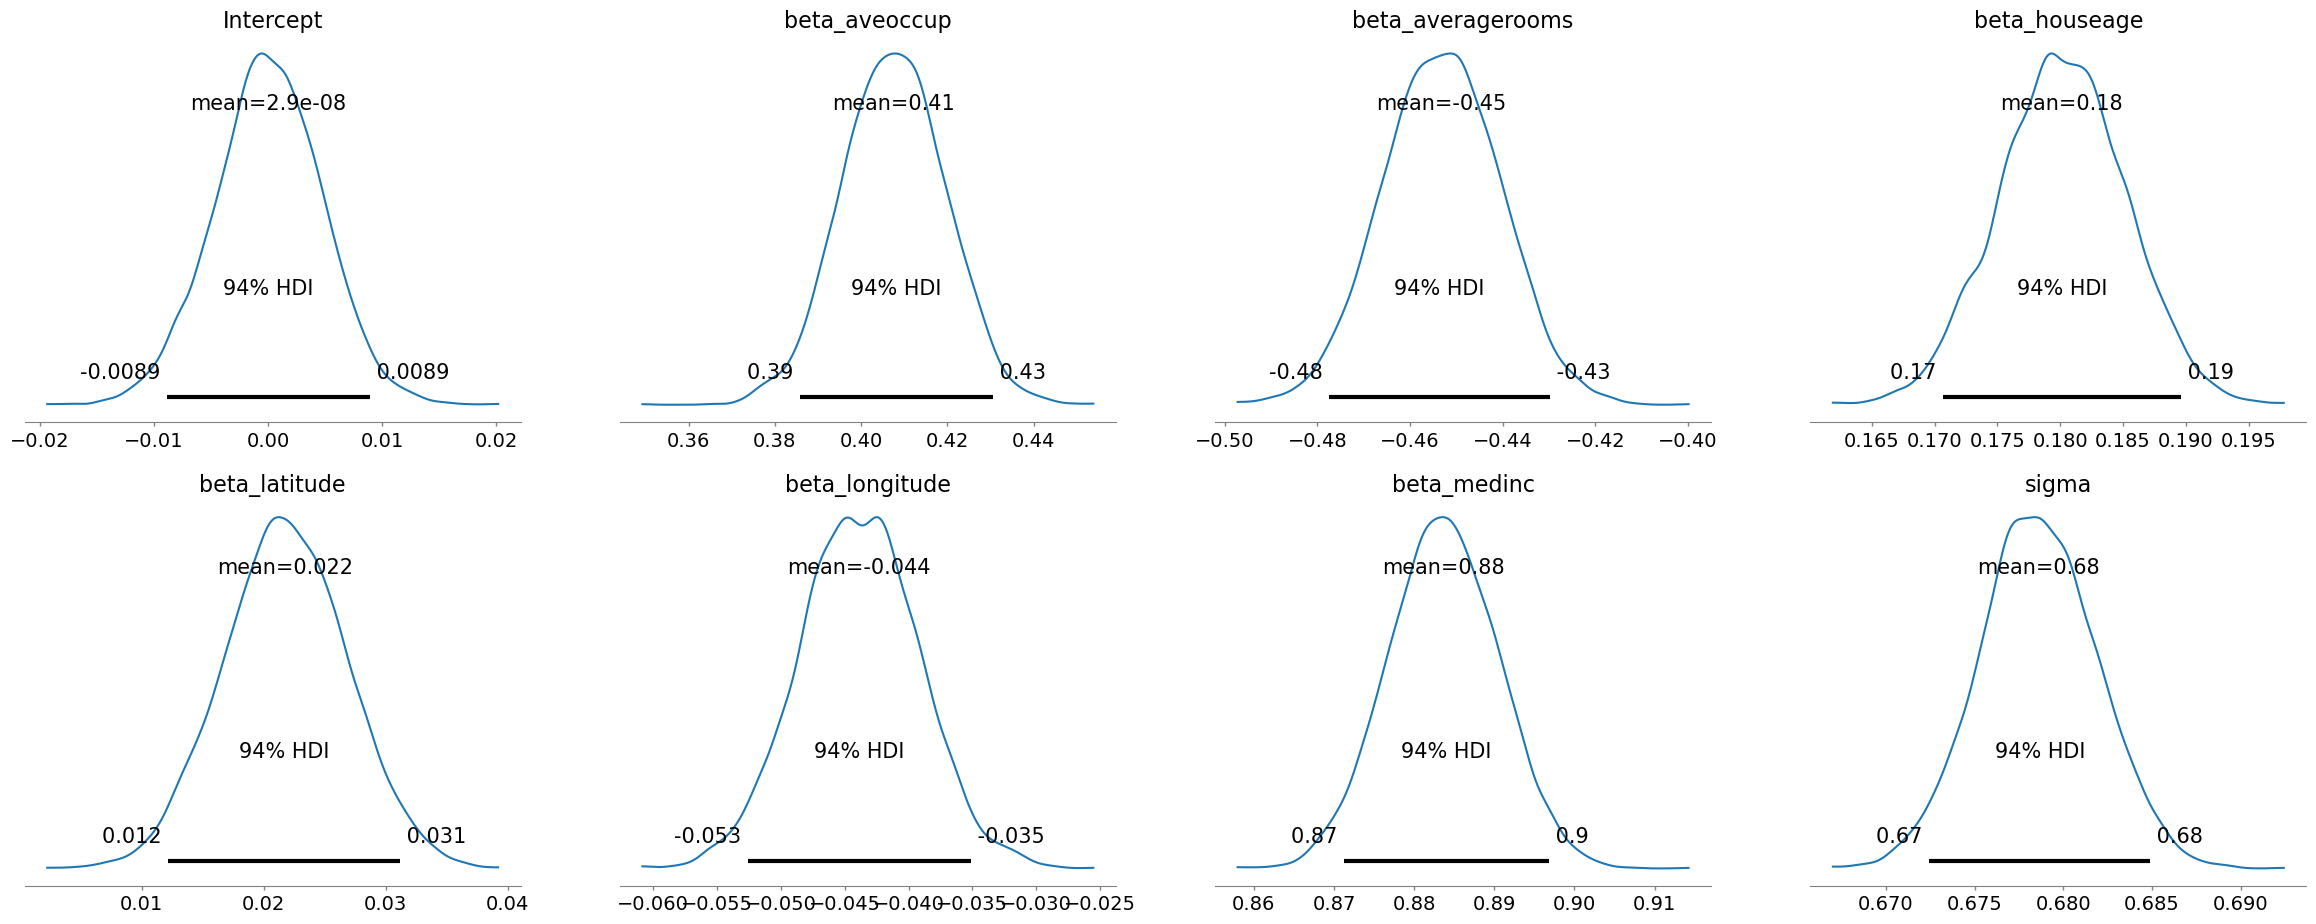

In [11]:
az.plot_posterior(trace);

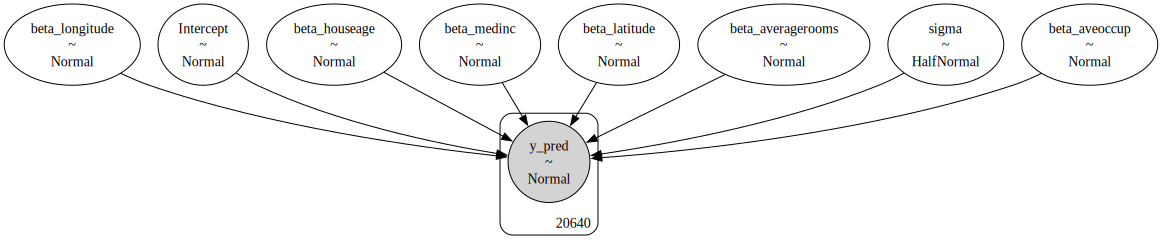

In [12]:
# Graph out model structure
pm.model_to_graphviz(bayesian_model)

In [13]:
# Posterior Predictive Check
ppc = pm.sample_posterior_predictive(trace, model=bayesian_model)

Sampling: [y_pred]


Output()

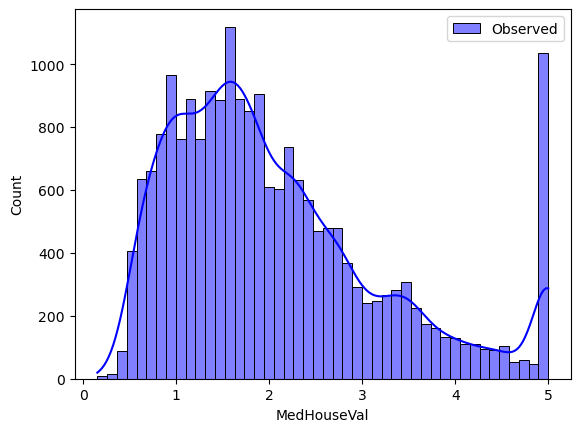

In [14]:
# Compare observed data to simulated posterior data
sns.histplot(y, color='blue', label='Observed', kde=True)
# sns.histplot(ppc.posterior_predictive.y_pred.mean(axis=0), color='orange', label='Posterior Predictive', kde=True)
plt.legend()
plt.show()

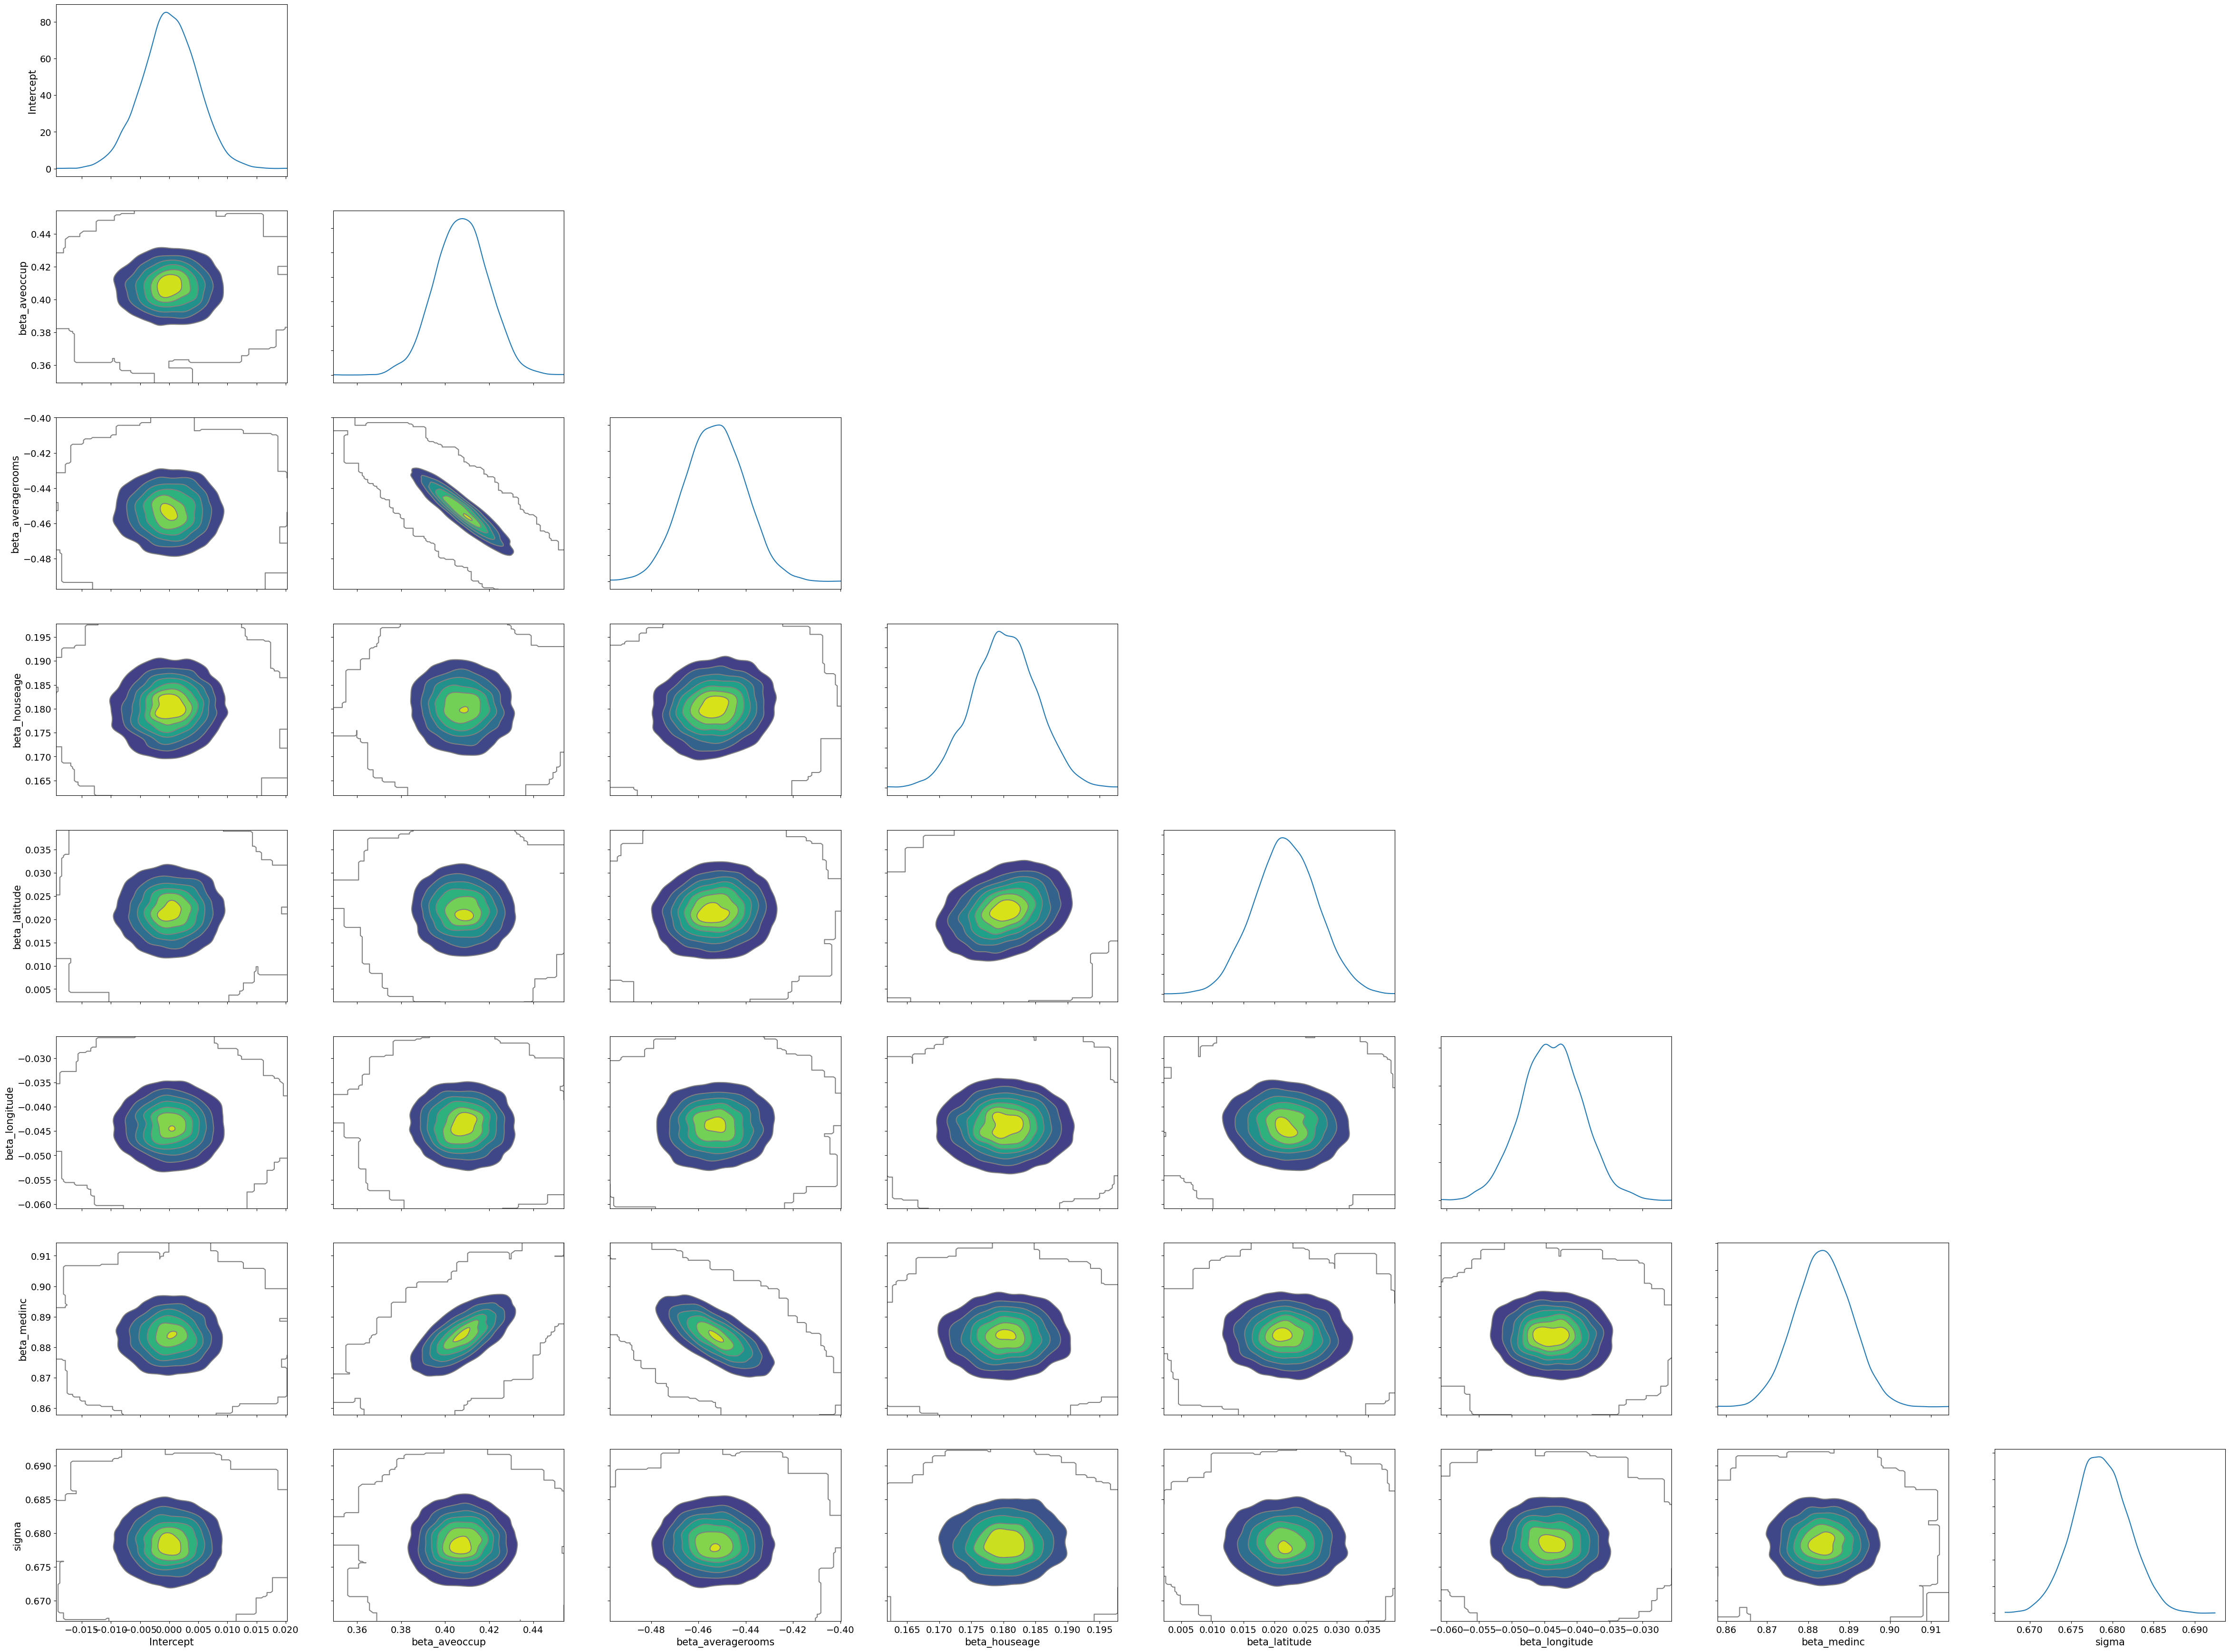

In [15]:
# Pair Plot (Joint Posterior Distributions)
az.plot_pair(trace, kind="kde", marginals=True);

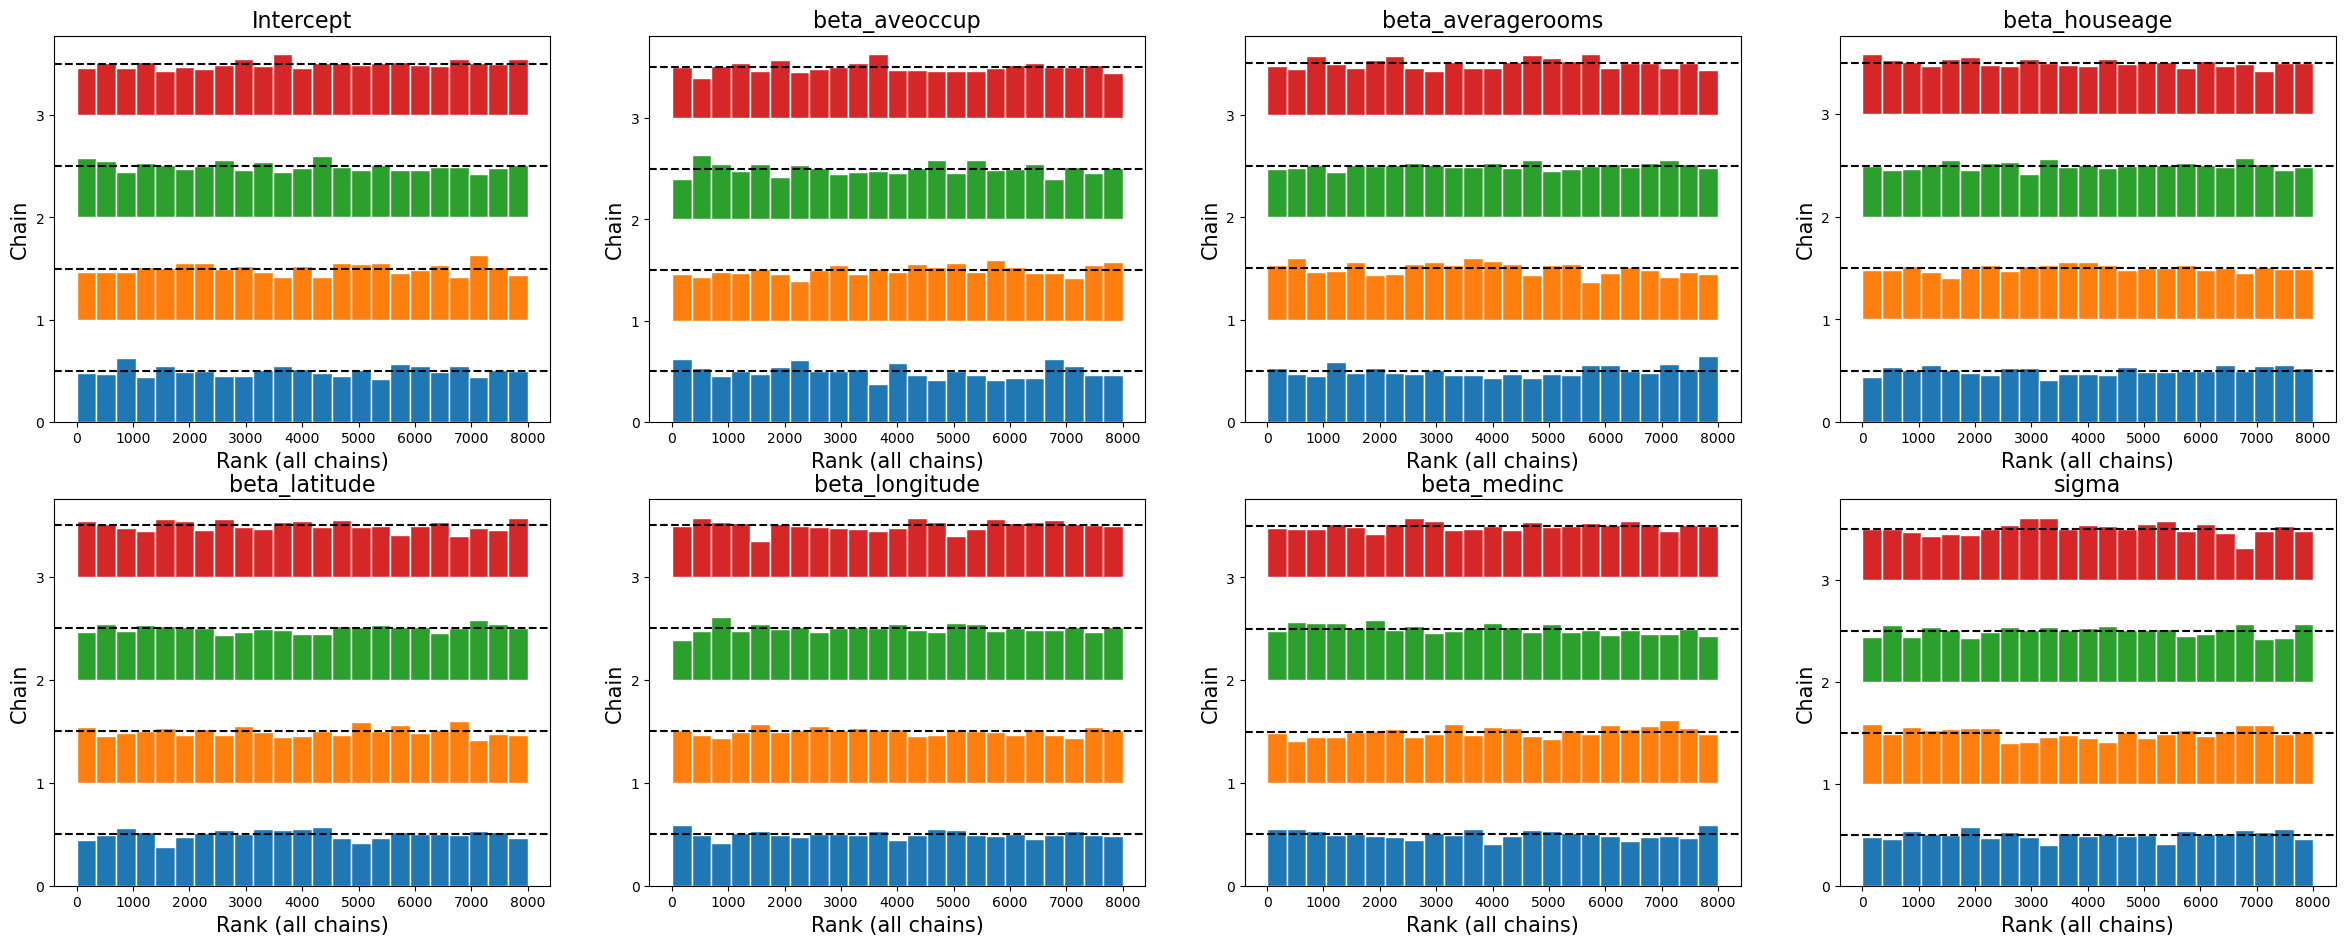

In [18]:
# Rank Plot
az.plot_rank(trace);
plt.show();

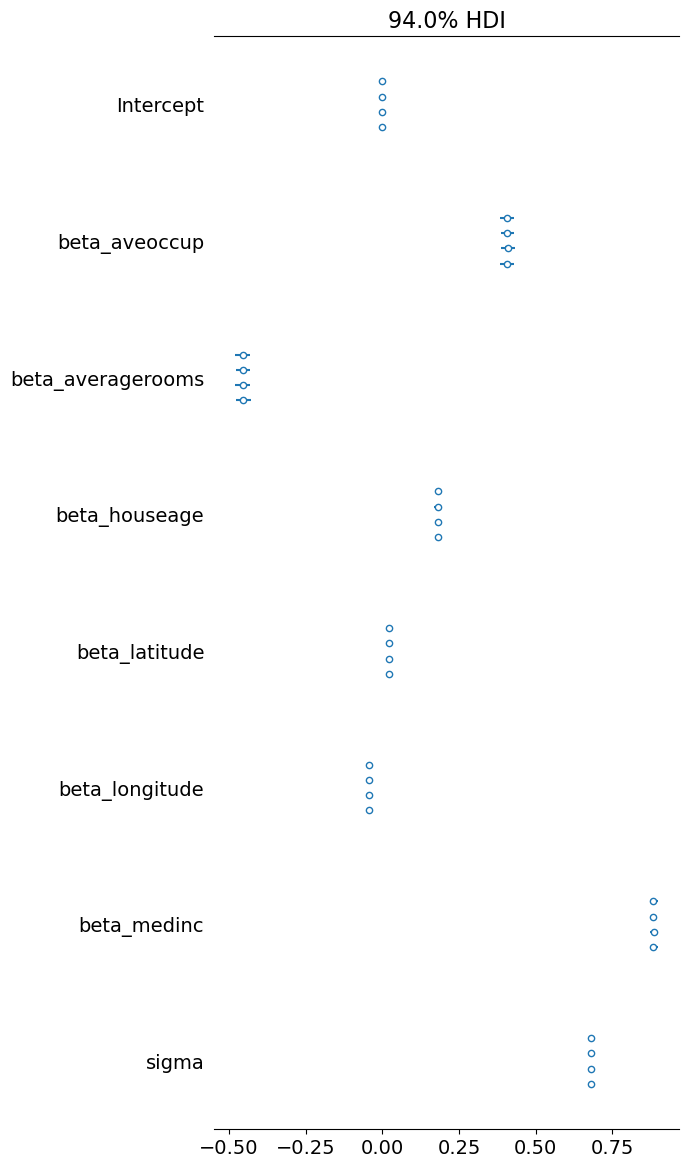

In [19]:
# Posterior Interval Plot (HDI Plot)
az.plot_forest(trace);

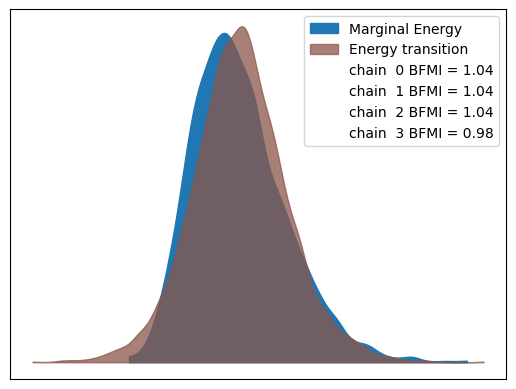

In [20]:
az.plot_energy(trace)
plt.show()

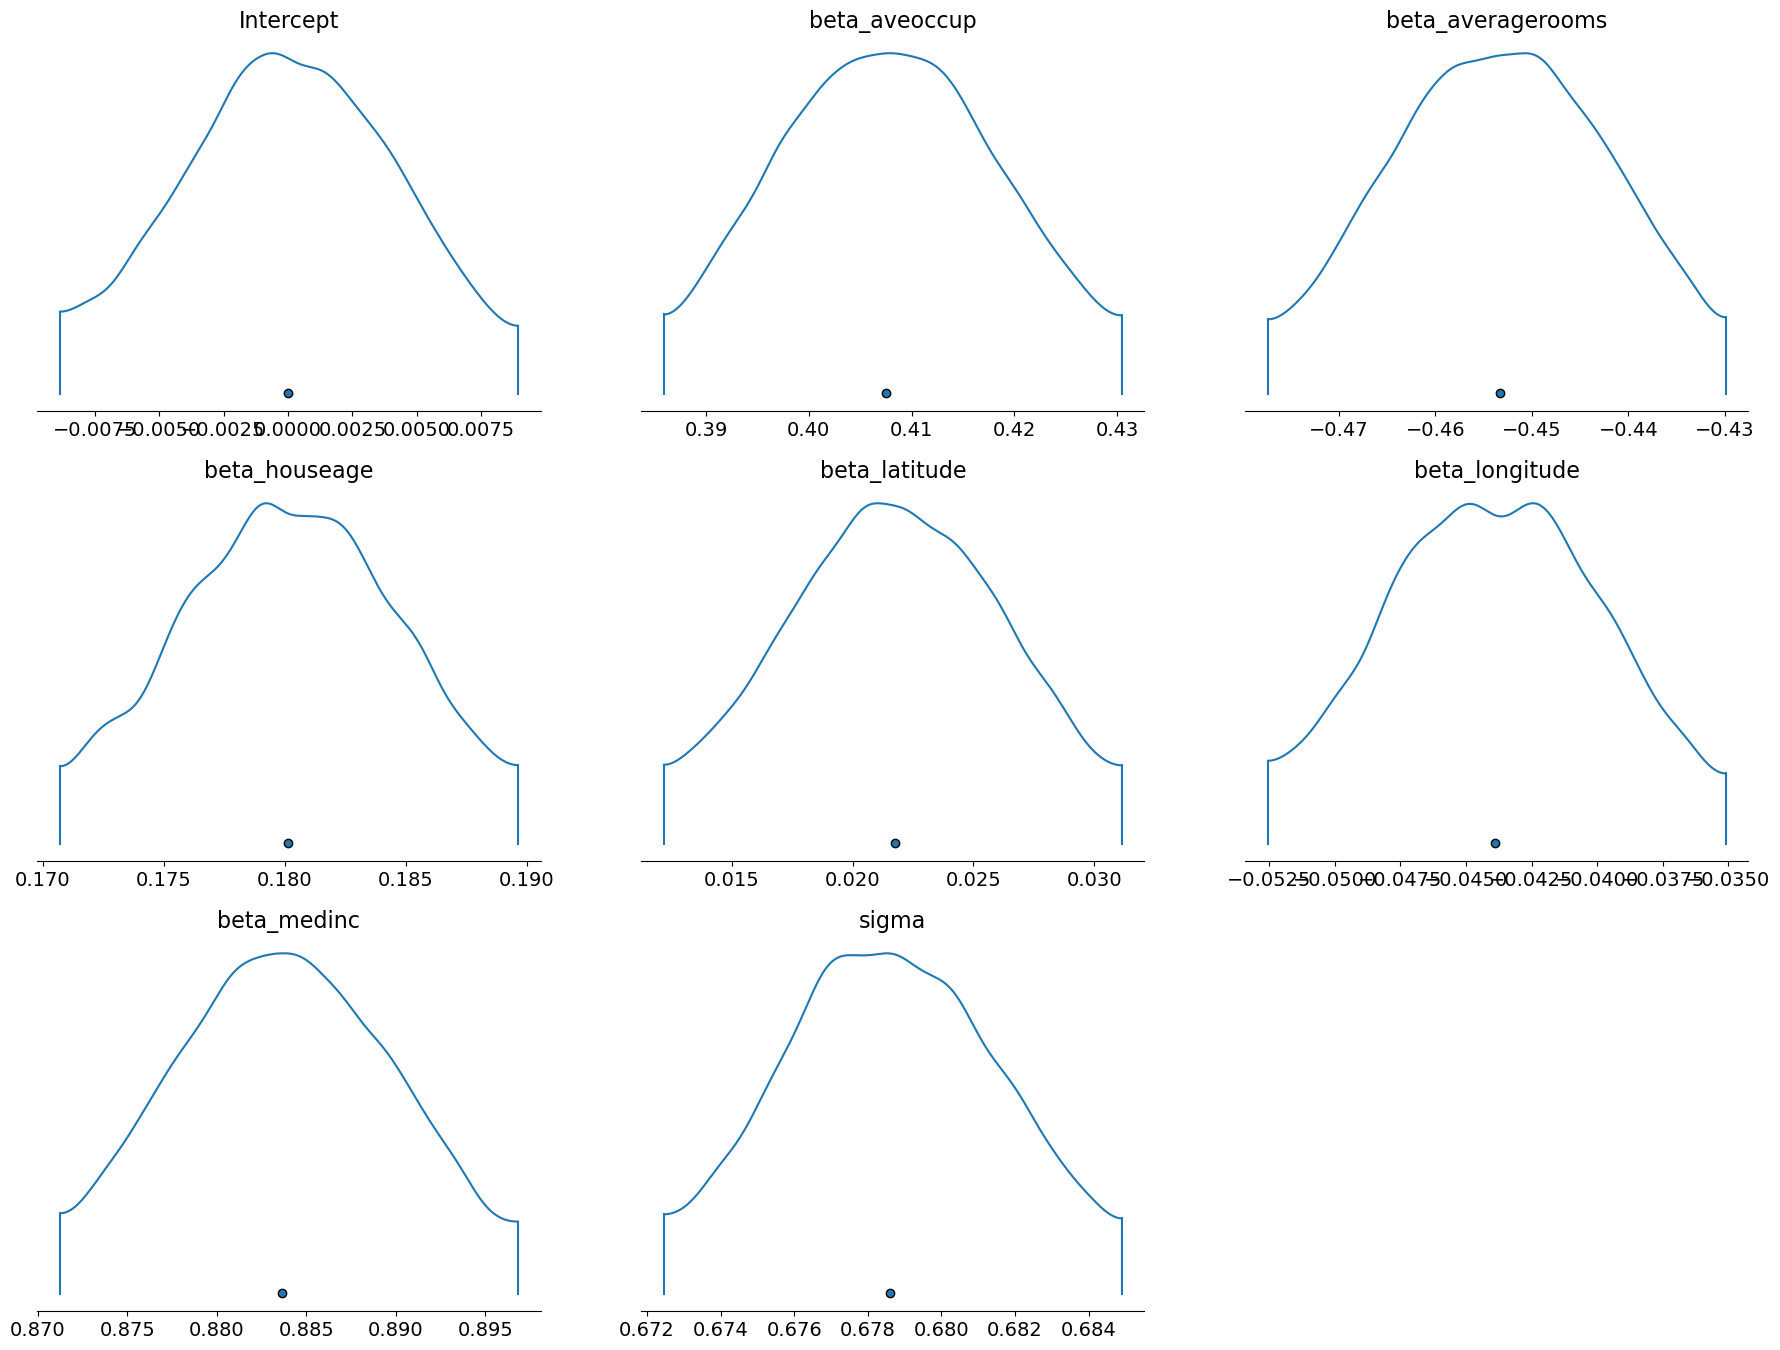

In [21]:
# az.plot_cdf(trace)
az.plot_density(trace)
plt.show()

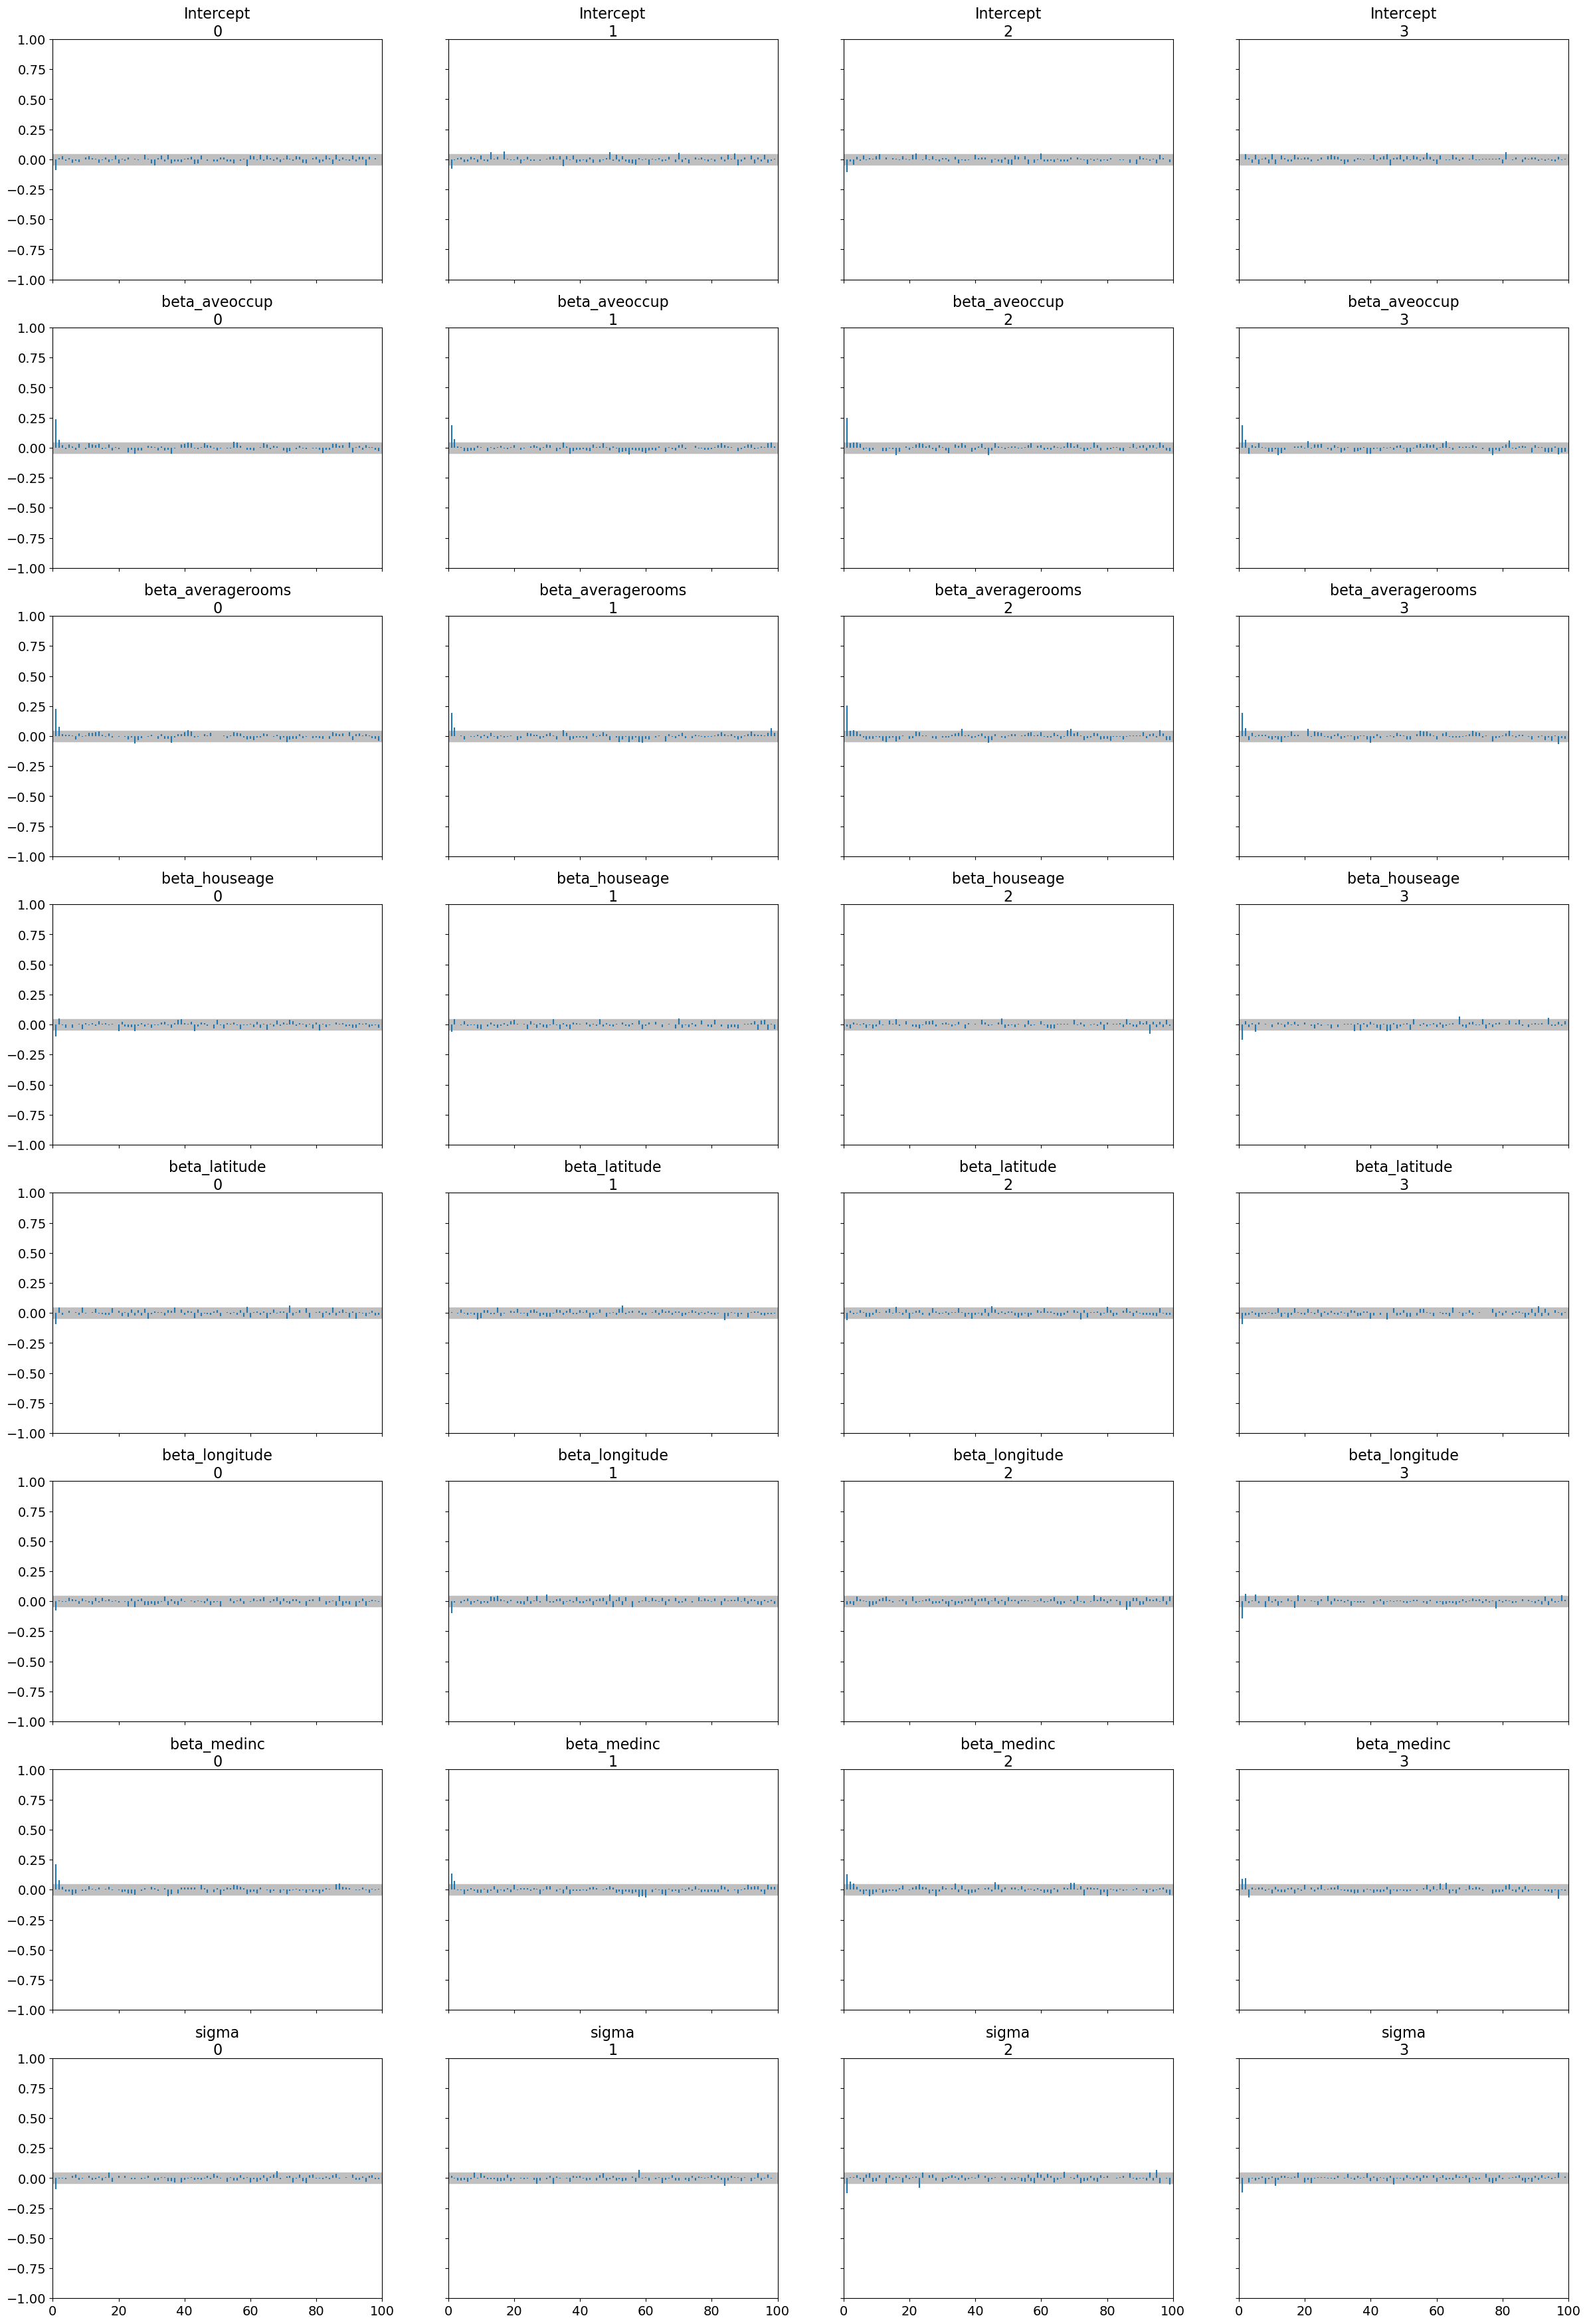

In [22]:
# az.plot_corr(trace)
az.plot_autocorr(trace)
plt.show()

<br>

***

<Br>

## Continuous/Binary Target Model

- Model: Predicting continuous target (Performance Index in this case)
- Dataset: Student Performance Dataset

### Prep Data

In [25]:
# !kaggle datasets download -d nikhil7280/student-performance-multiple-linear-regression

# # Define the path to the downloaded zip file
# zip_file_path = 'student-performance-multiple-linear-regression.zip'

# # Define the directory to extract the contents
# extract_dir = 'student_performance_data'

# # Create the directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# # Extract the contents of the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f'Dataset extracted to {extract_dir}')

df = pd.read_csv('./student_performance_data/Student_performance.csv')
df.head(3)

Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [27]:
df.shape

(10000, 6)

In [28]:
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
No     5052
Yes    4948
Name: count, dtype: int64

In [29]:
le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
0    5052
1    4948
Name: count, dtype: int64

In [30]:
for i in df.columns:
    print(f"{i} : {df[i].value_counts(dropna=False)}")

Hours Studied : Hours Studied
1    1152
6    1133
7    1129
3    1119
9    1115
5    1094
8    1088
4    1085
2    1085
Name: count, dtype: int64
Previous Scores : Previous Scores
54    216
87    208
56    192
62    184
89    182
60    181
53    181
77    181
52    176
58    176
57    176
49    175
66    175
65    175
84    175
91    175
97    174
79    174
40    173
83    173
75    172
70    172
93    172
47    172
92    172
90    172
42    171
44    170
48    170
95    169
41    169
67    168
43    167
73    166
61    165
78    165
88    164
59    163
63    163
46    163
86    162
81    161
71    159
99    159
85    159
96    159
98    158
45    154
69    153
80    153
68    153
82    148
94    148
72    148
64    147
55    144
74    143
76    142
51    140
50    123
Name: count, dtype: int64
Extracurricular Activities : Extracurricular Activities
0    5052
1    4948
Name: count, dtype: int64
Sleep Hours : Sleep Hours
8    1804
7    1676
6    1673
9    1622
4    1619
5    1606
Name: 

In [31]:
df.isna().any()

Hours Studied                       False
Previous Scores                     False
Extracurricular Activities          False
Sleep Hours                         False
Sample Question Papers Practiced    False
Performance Index                   False
dtype: bool

In [32]:
# df = df[~df.duplicated()]
# df = df.dropna().astype(float)
# columns = df.columns.values[:-1] 
df = df.astype(float)

In [33]:
# Create target variables
df['Pass Fail'] = df['Performance Index'].apply(lambda x: 1 if x >= 50 else 0)
y_lin = df['Performance Index']
y_log = df['Pass Fail']
y_lin = y_lin.astype(float)
y_log = y_log.astype(float)


X = df.drop(columns=['Performance Index', 'Pass Fail'])
X = X.astype(float)

In [34]:
df.head()

Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0            7.0             99.0                         1.0          9.0   
1            4.0             82.0                         0.0          4.0   
2            8.0             51.0                         1.0          7.0   
3            5.0             52.0                         1.0          5.0   
4            7.0             75.0                         0.0          8.0   

   Sample Question Papers Practiced  Performance Index  Pass Fail  
0                               1.0               91.0          1  
1                               2.0               65.0          1  
2                               2.0               45.0          0  
3                               2.0               36.0          0  
4                               5.0               66.0          1

In [35]:
df['Performance Index'].max()

100.0

In [36]:
df['Performance Index'].min()

10.0

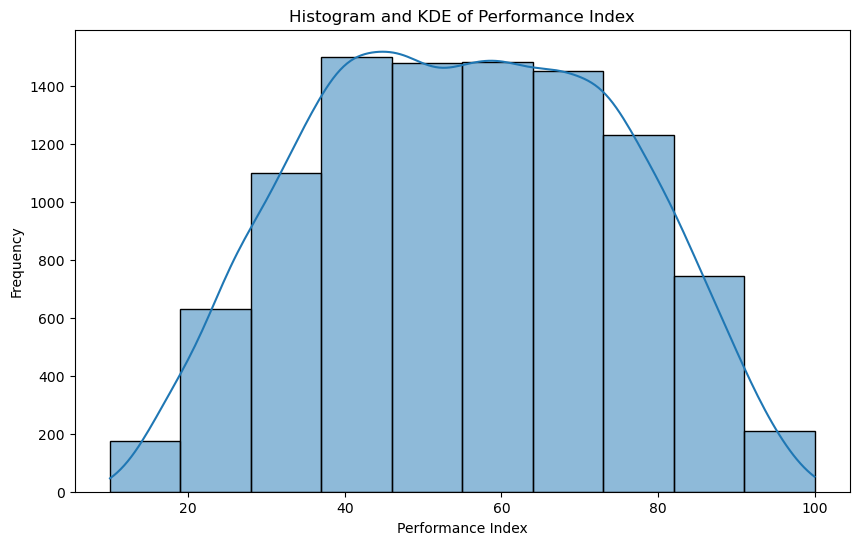

In [37]:
# Histogram & KDE plot of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Performance Index'], kde=True, bins=10)
plt.title('Histogram and KDE of Performance Index')
plt.xlabel('Performance Index')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Sample Quantiles')

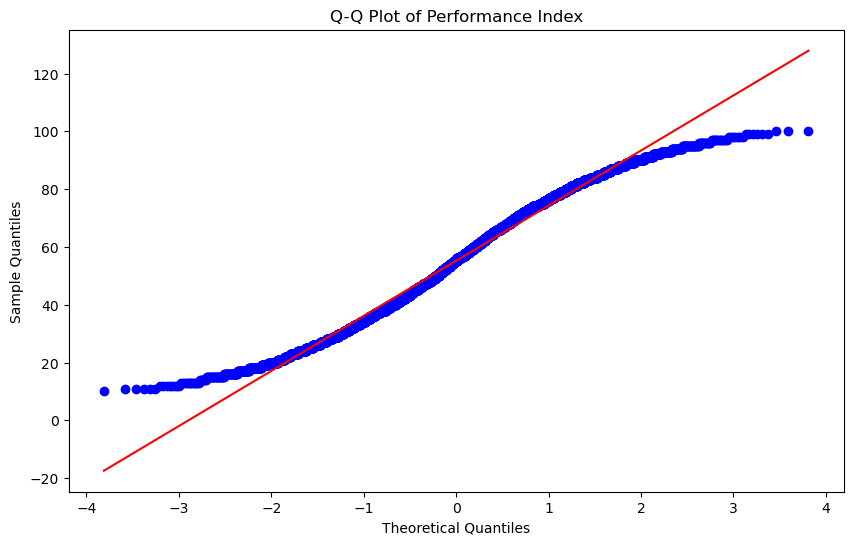

In [38]:
# QQ Plot for Target
plt.figure(figsize=(10, 6))
stats.probplot(df['Performance Index'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Performance Index')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

### Build Model

In [41]:
# ==================================================== #
# Optional to Standardize Variables                    #
# ==================================================== #

# pros: sampling efficiency (NUTS), numerical stability (MCMC), you can transform back to normal at the end (or not - interpret the standard deviation)
# I saw it go from 48 seconds to 16 seconds
# x_norm = (x - x.mean()) / x.std() # x was created above!
df['Performance Index Scaled'] = df['Performance Index'] / 100
features = df[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
X_normalized = (features - features.mean()) / features.std()
X_normalized.head()

Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0       0.775149         1.704090                    1.010404     1.456132   
1      -0.383461         0.723876                   -0.989604    -1.492220   
2       1.161352        -1.063573                    1.010404     0.276791   
3       0.002742        -1.005913                    1.010404    -0.902549   
4       0.775149         0.320259                   -0.989604     0.866462   

   Sample Question Papers Practiced  
0                         -1.249691  
1                         -0.900937  
2                         -0.900937  
3                         -0.900937  
4                          0.145326

In [40]:
df['Performance Index Scaled'].max()

1.0

In [42]:
%%time
with pm.Model() as linear_model:

     # Define priors for intercept and coefficients (using sigma=1 because it's standardized)
    intercept = pm.Normal("Intercept", mu=0, sigma=1)
    beta_hours = pm.Normal("Beta_Hours_Studied", mu=0, sigma=1)
    beta_prev_scores = pm.Normal("Beta_Previous_Scores", mu=0, sigma=1)
    beta_extra = pm.Normal("Beta_Extracurricular_Activities", mu=0, sigma=1)
    beta_sleep = pm.Normal("Beta_Sleep_Hours", mu=0, sigma=1)
    beta_samples = pm.Normal("Beta_Sample_Questions", mu=0, sigma=1)


    # Linear regression model using normalized predictors
    mu = (intercept
        + beta_hours * X_normalized['Hours Studied']
        + beta_prev_scores * X_normalized['Previous Scores']
        + beta_extra * X_normalized['Extracurricular Activities']
        + beta_sleep * X_normalized['Sleep Hours']
        + beta_samples * X_normalized['Sample Question Papers Practiced']
        )

    # Beta distribution parameters (shape to be constrained to be >0)
    alpha = pm.Exponential("alpha", 1)
    beta = pm.Exponential("beta", 1)
    p = pm.Deterministic("p", pm.math.sigmoid(mu)) # Sigmoid to bound in (0,1)

    # Likelihood
    performance = pm.Beta("Performance Index", alpha=alpha * p, beta=beta * (1-p), observed=df['Performance Index Scaled'])

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Intercept': array(-0.64701846), 'Beta_Hours_Studied': array(0.15043825), 'Beta_Previous_Scores': array(-0.99105162), 'Beta_Extracurricular_Activities': array(0.12194617), 'Beta_Sleep_Hours': array(-0.3851794), 'Beta_Sample_Questions': array(0.77326593), 'alpha_log__': array(-0.81497035), 'beta_log__': array(-0.77973953)}

Logp initial evaluation results:
{'Intercept': -1.13, 'Beta_Hours_Studied': -0.93, 'Beta_Previous_Scores': -1.41, 'Beta_Extracurricular_Activities': -0.93, 'Beta_Sleep_Hours': -0.99, 'Beta_Sample_Questions': -1.22, 'alpha': -1.26, 'beta': -1.24, 'Performance Index': inf}
You can call `model.debug()` for more details.

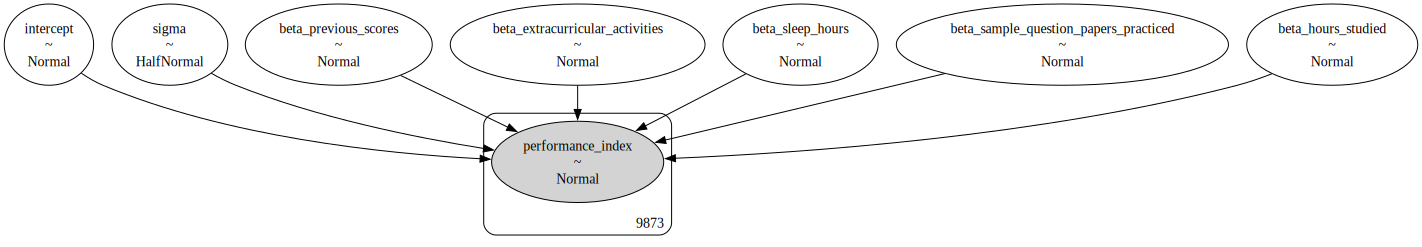

In [43]:
pm.model_to_graphviz(linear_model)

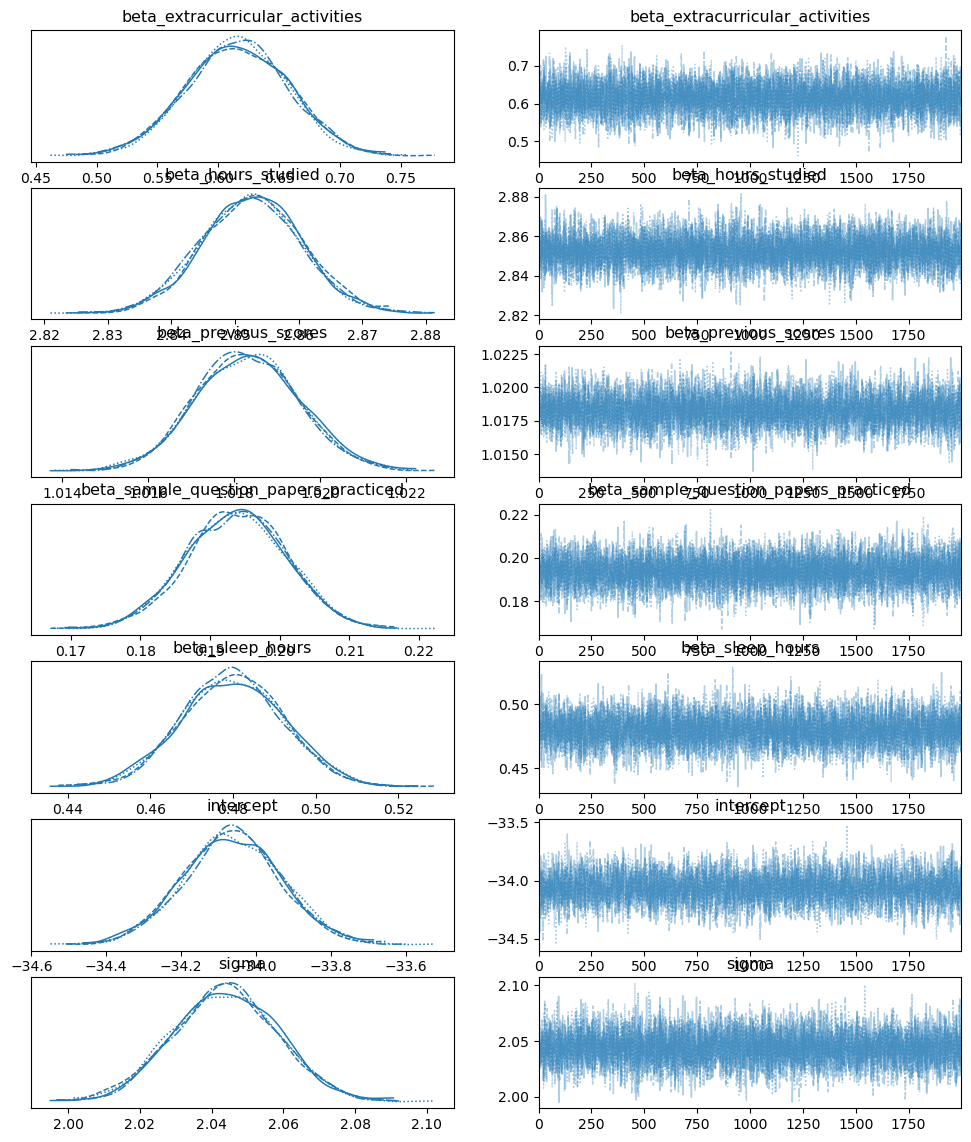

In [44]:
# Visualize trace
az.plot_trace(trace);
plt.show();

In [45]:
# Summary of the posterior distributions
az.summary(trace, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  \
beta_extracurricular_activities         0.616  0.041     0.536      0.697   
beta_hours_studied                      2.853  0.008     2.837      2.868   
beta_previous_scores                    1.018  0.001     1.016      1.021   
beta_sample_question_papers_practiced   0.194  0.007     0.180      0.207   
beta_sleep_hours                        0.480  0.012     0.455      0.503   
intercept                             -34.064  0.129   -34.327    -33.822   
sigma                                   2.044  0.015     2.015      2.072   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_extracurricular_activities            0.000    0.000    8062.0    5250.0   
beta_hours_studied                         0.000    0.000    8590.0    5974.0   
beta_previous_scores                       0.000    0.000    6206.0    5118.0   
beta_sample_question_papers_practiced      0.000    0.000    7183.0    5427.0   
beta_sleep_hours                           0.000    0.000    6298.0    5309.0   
intercept                                  0.002    0.001    4795.0    4866.0   
sigma                                      0.000    0.000    8046.0    5629.0   

                                       r_hat  
beta_extracurricular_activities          1.0  
beta_hours_studied                       1.0  
beta_previous_scores                     1.0  
beta_sample_question_papers_practiced    1.0  
beta_sleep_hours                         1.0  
intercept                                1.0  
sigma                                    1.0

In [48]:
# Posterior predictive checks
ppc = pm.sample_posterior_predictive(trace, model=linear_model)

Sampling: [performance_index]


Output()

AttributeError: 'InferenceData' object has no attribute 'prior'

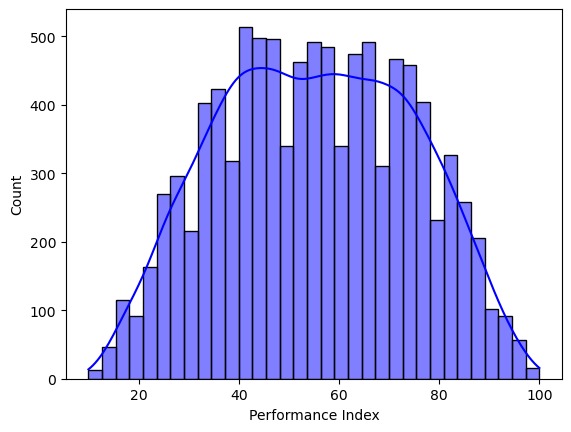

In [49]:
# Compare observed data to simulated posterior data
sns.histplot(y_lin, color='blue', label='Observed', kde=True)
sns.histplot(ppc.prior(axis=0), color='orange', label='Posterior Predictive', kde=True)
plt.legend()
plt.show()

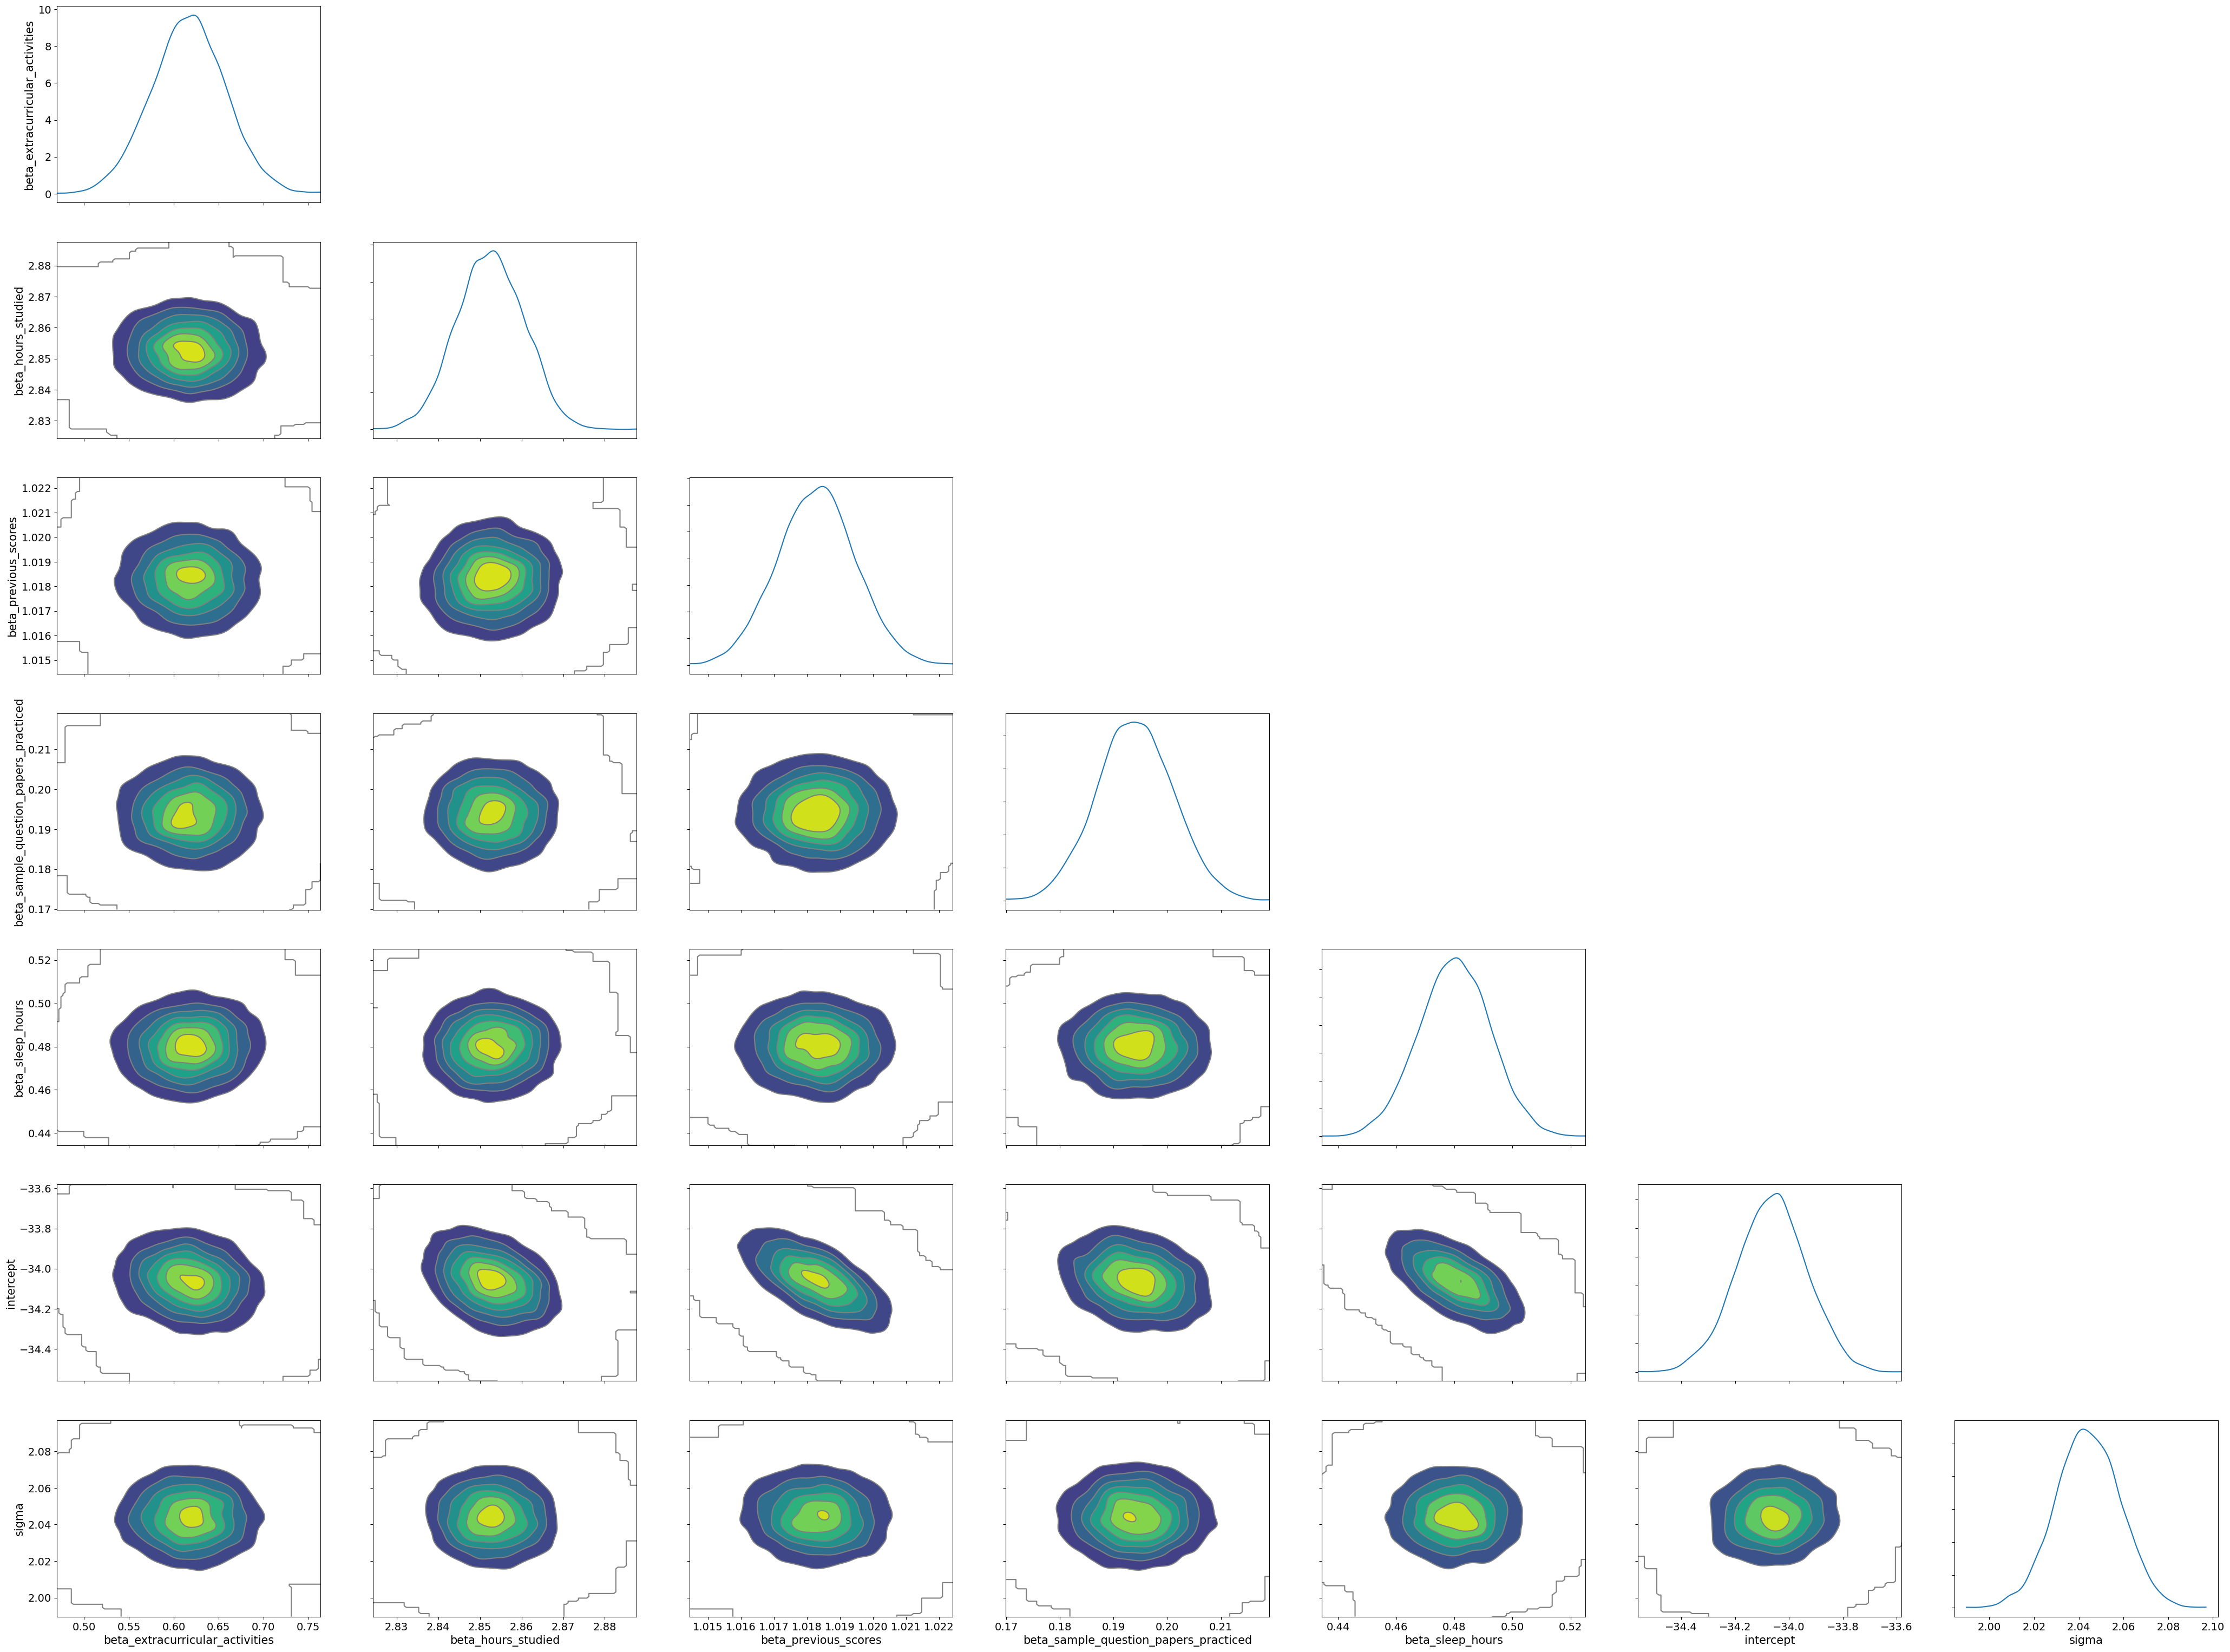

In [85]:
# Pair Plot
az.plot_pair(trace, kind="kde", marginals=True);

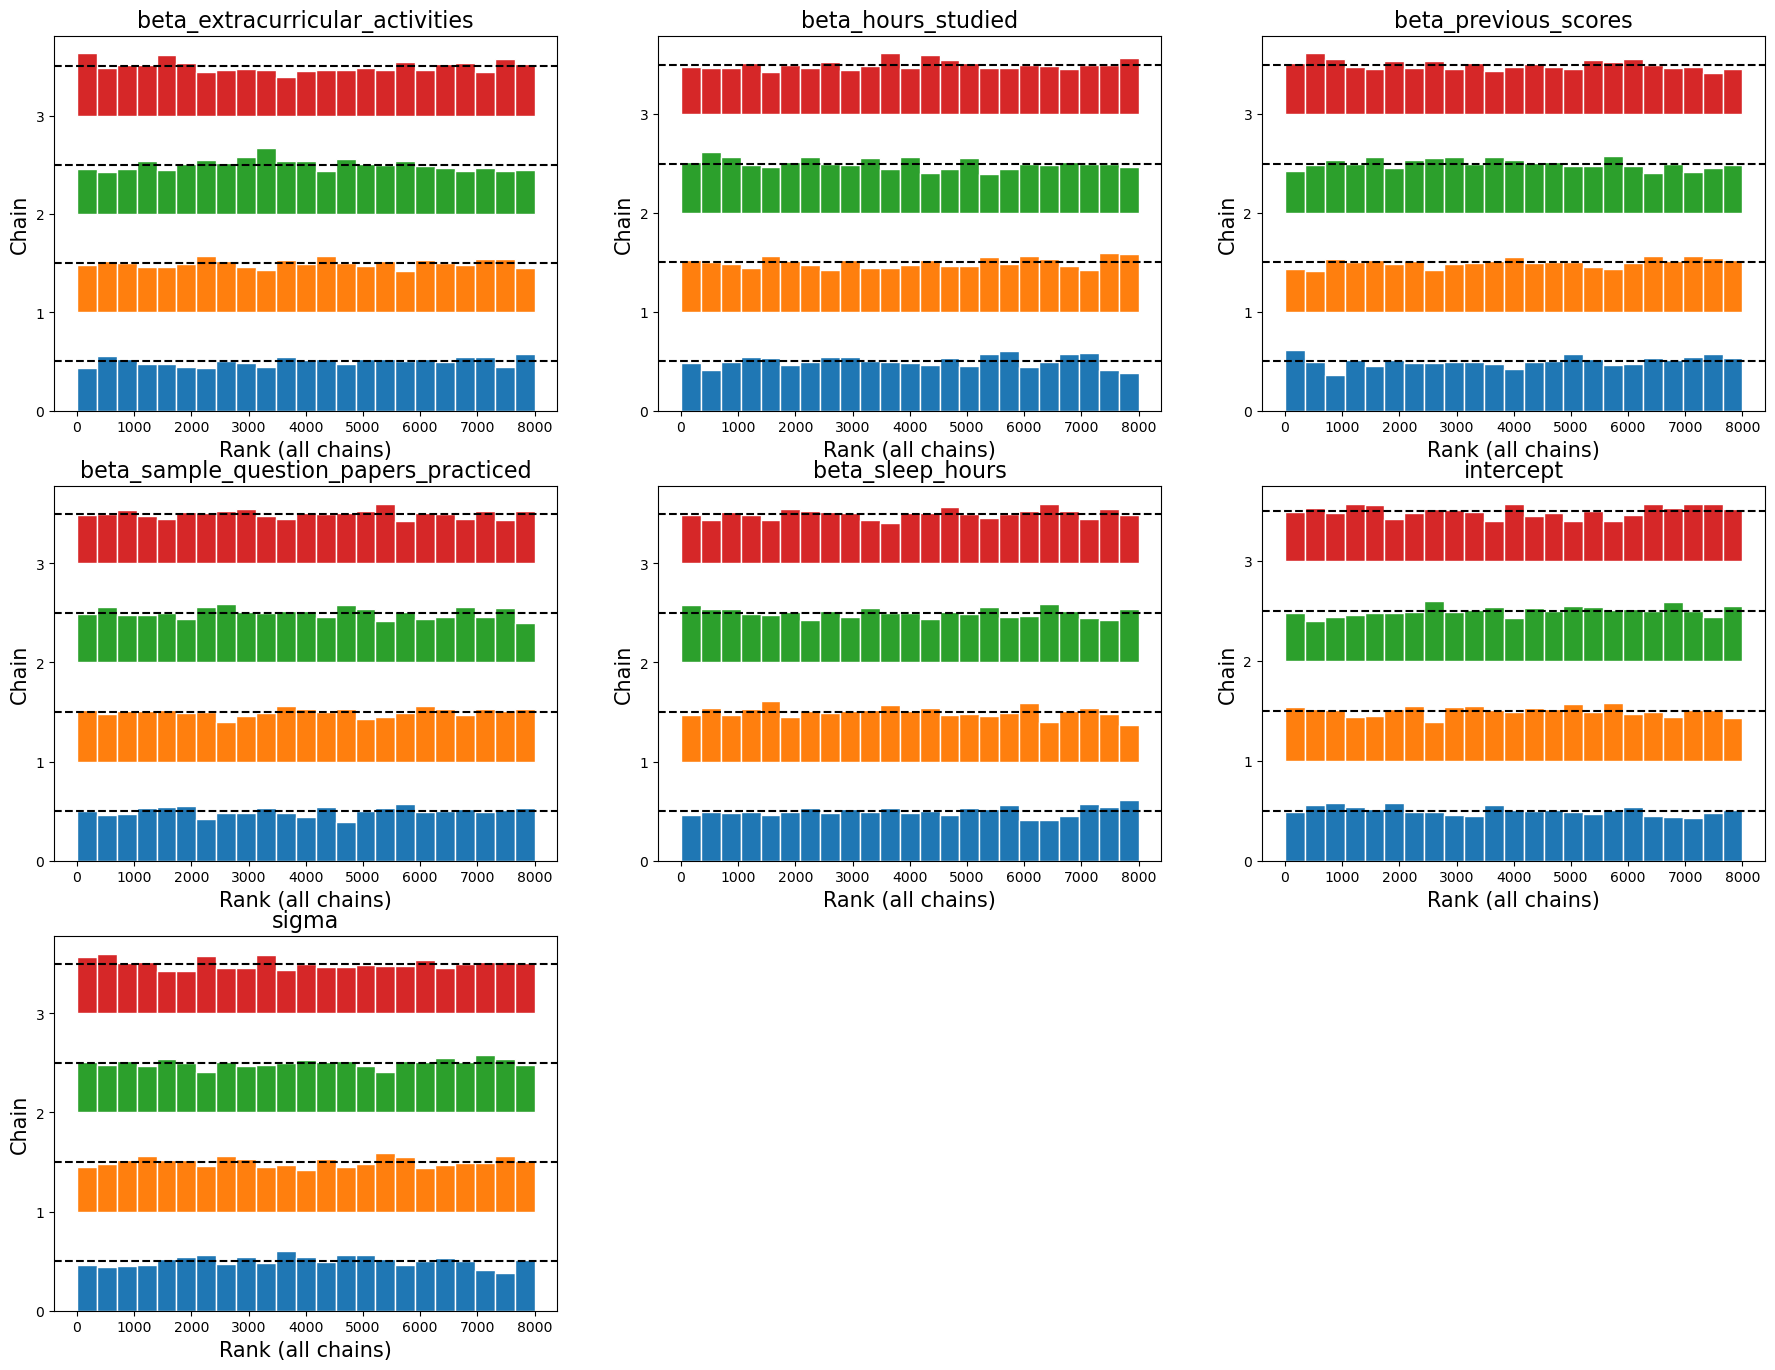

In [86]:
# Rank Plot
az.plot_rank(trace);
plt.show();

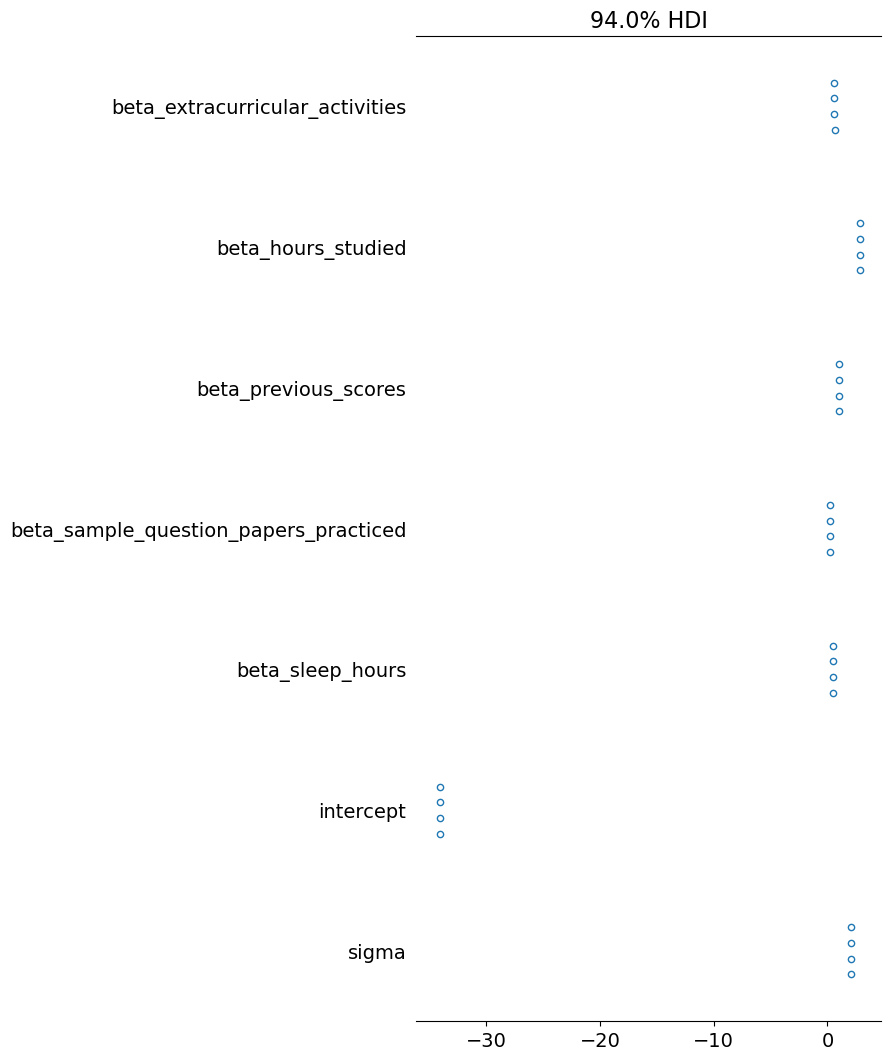

In [89]:
# Posterior Interval Plot
az.plot_forest(trace);

In [92]:
# Leave One Out Plot
loo = az.loo(trace)
az.plot_loo_pit(loo)
plt.show()

TypeError: log likelihood not found in inference data object

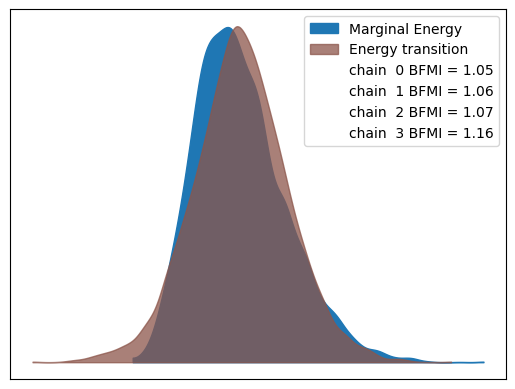

In [93]:
# Engery Plot
az.plot_energy(trace)
plt.show()

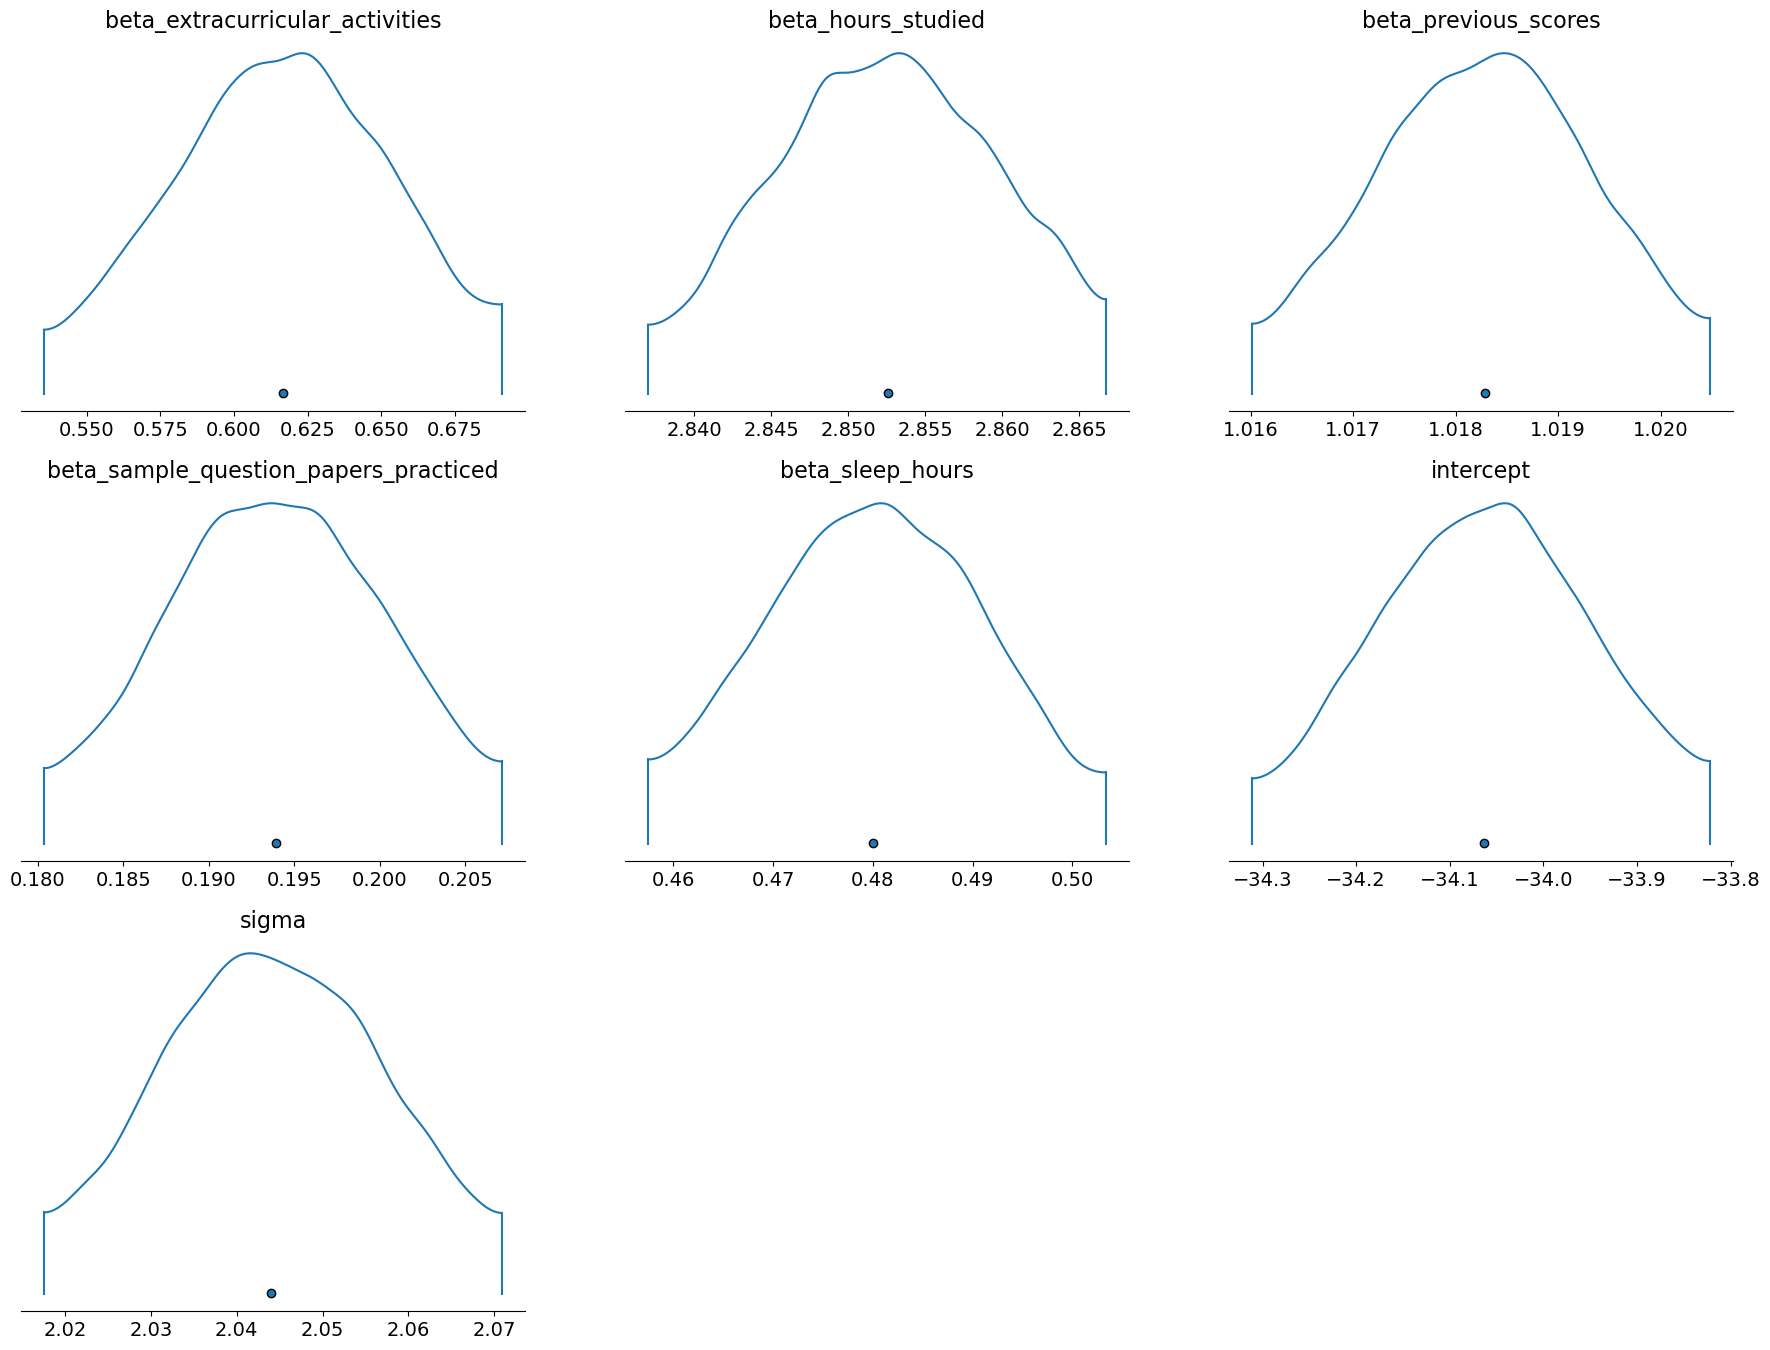

In [95]:
# Cumulative Distribution Function Plot
az.plot_density(trace);
plt.show();

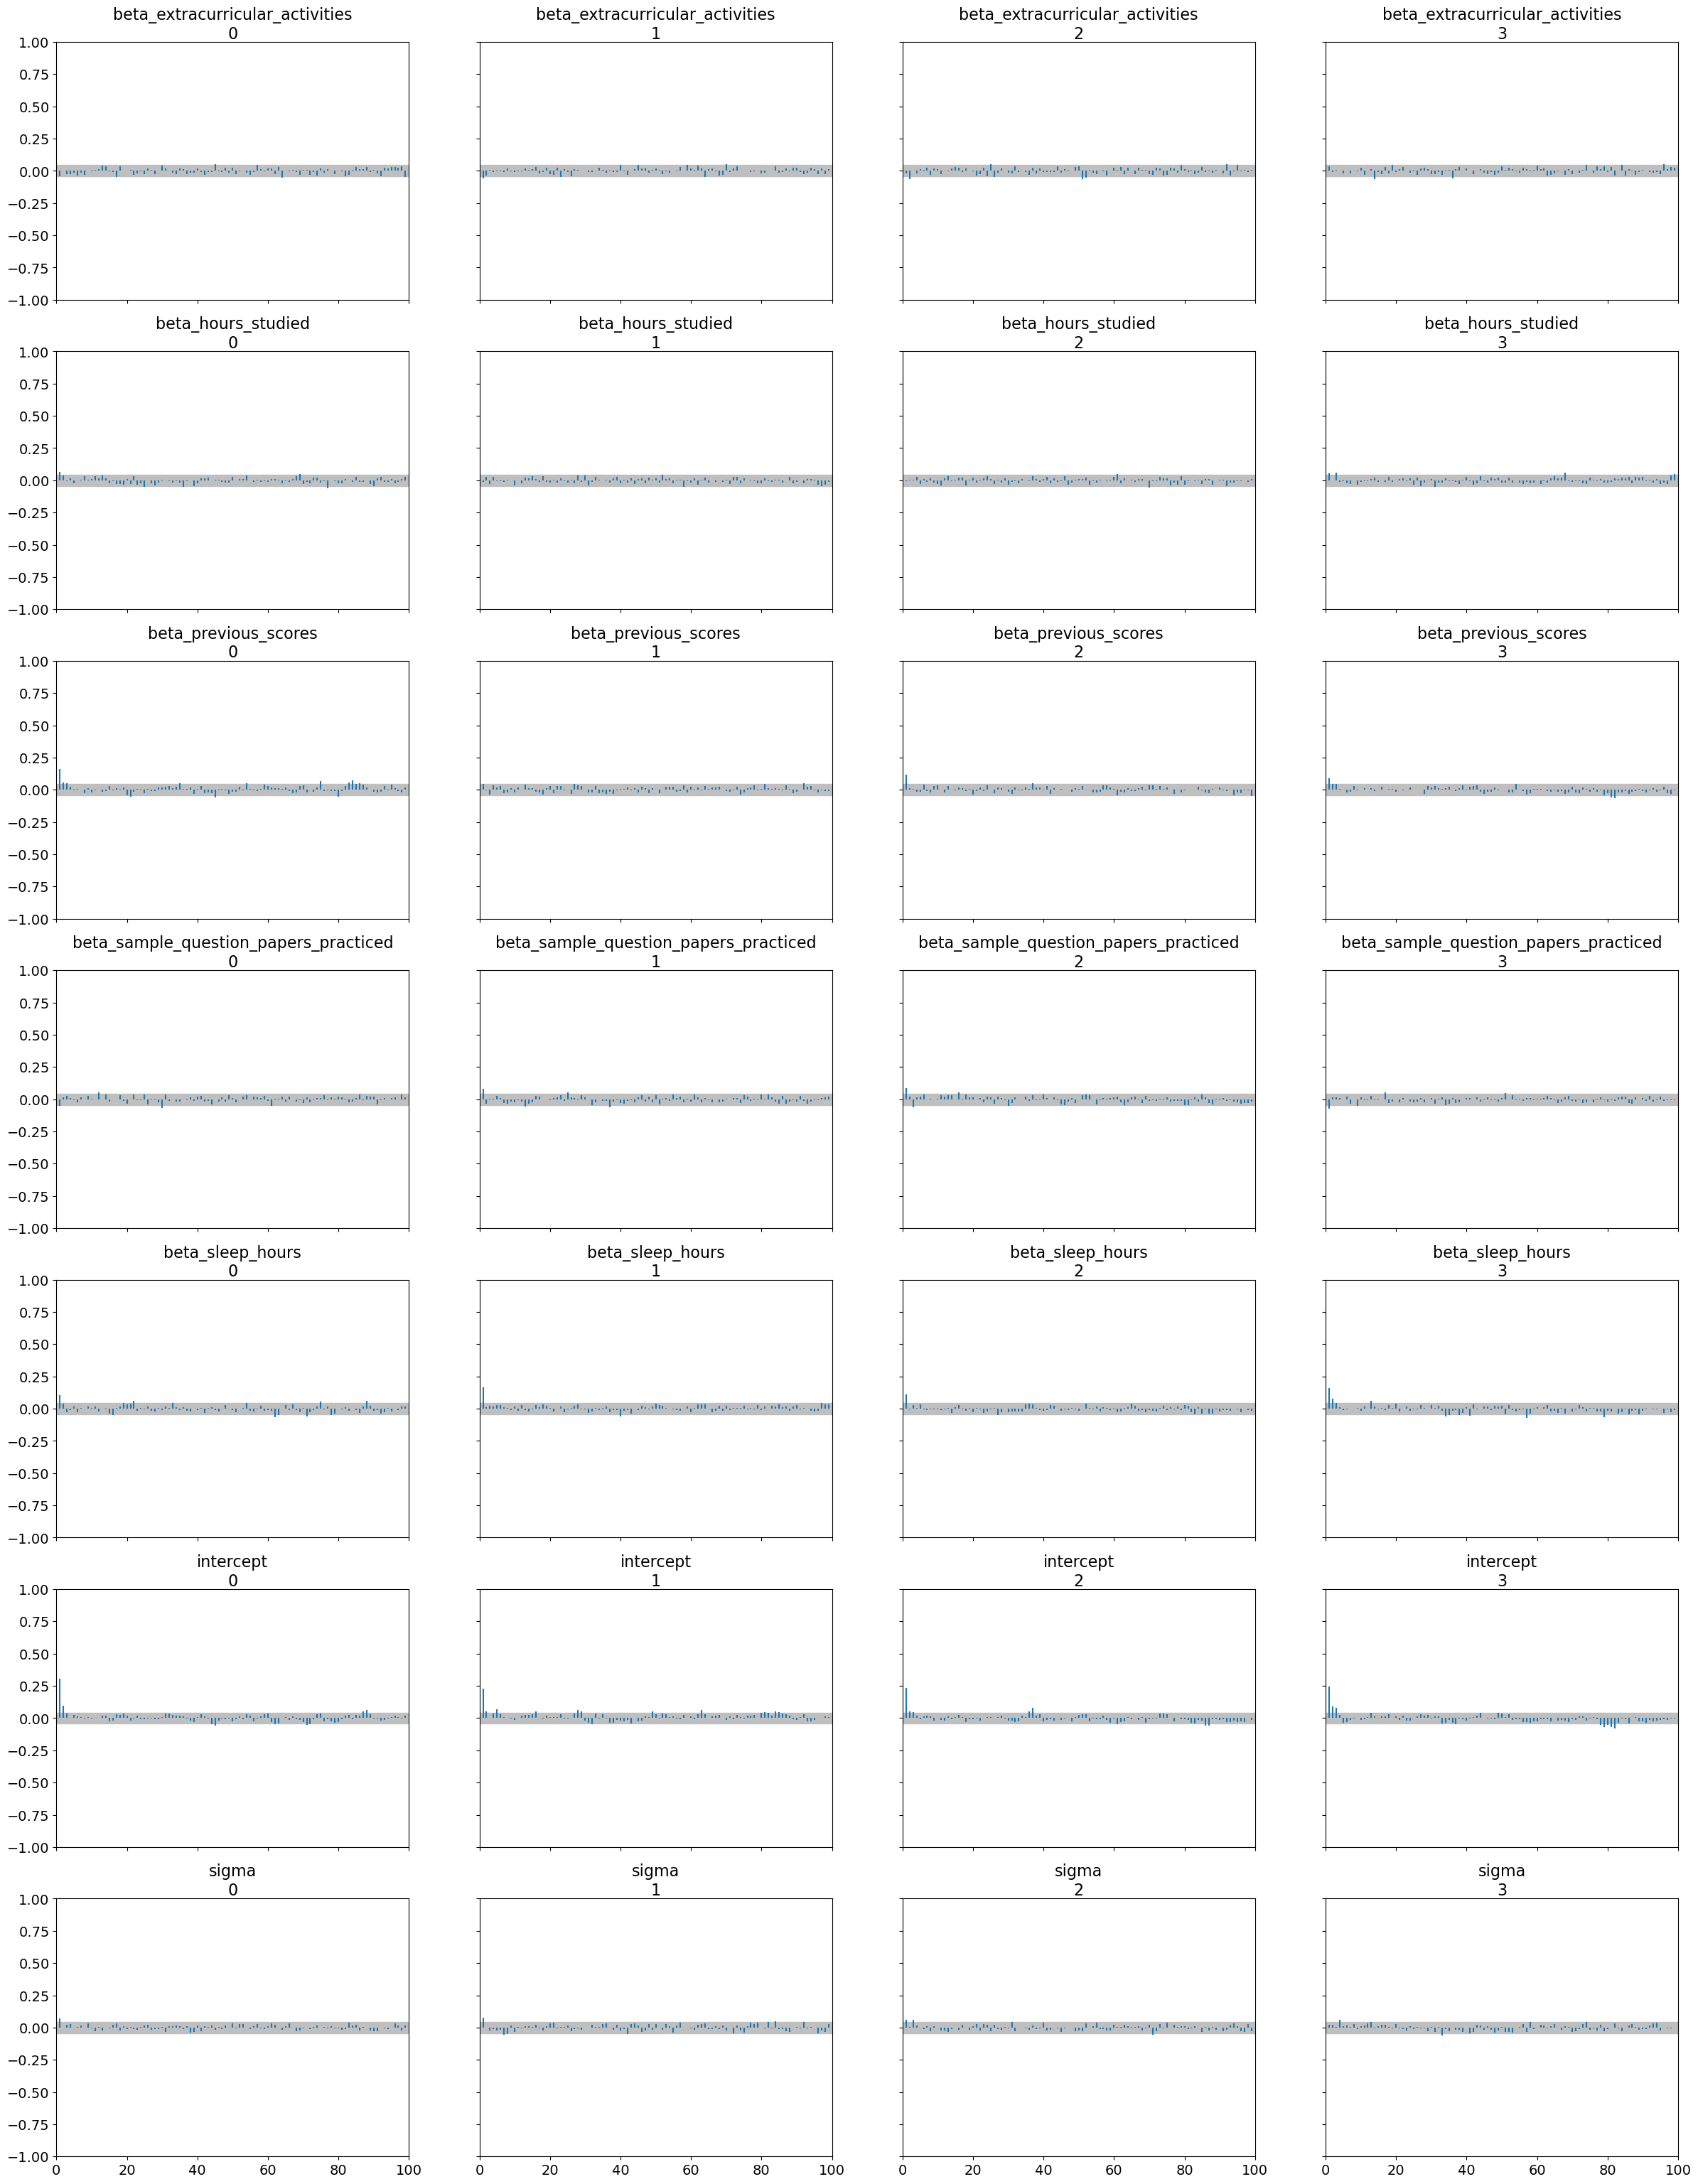

In [96]:
# Correlation Matrix of Parameters
az.plot_autocorr(trace)
plt.show()

<br>

***

<Br>

## Binary Target Model

- Model: Predicting binary target (Pass_Fail in this case)
- Dataset: Student Performance Dataset

In [3]:
df = pd.read_csv('./student_performance_data/Student_performance.csv')
df.head()

Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0

In [4]:
le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
0    5052
1    4948
Name: count, dtype: int64

In [5]:
df['pass_fail'] = np.where(df['Performance Index'] > 60, 1, 0)
y_log = df['pass_fail']
y_log = y_log.astype(float)
df['pass_fail'].value_counts(dropna=False)

pass_fail
0    5878
1    4122
Name: count, dtype: int64

In [6]:
# Standardize variables
scaler = StandardScaler()
X = df[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
X_scaled = scaler.fit_transform(X)

# Convert scaled features to tensors
X_shared = pm.floatX(X_scaled)
y_shared = pm.floatX(y_log)

In [ ]:
%%time
with pm.Model() as logistic_model:

    # Independent variables
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_hours_studied = pm.Normal("beta_hours_studied", mu=0, sigma=1)
    beta_previous_scores = pm.Normal("beta_previous_scores", mu=0, sigma=1)
    beta_extracurricular_activities = pm.Normal("beta_extracurricular_activities", mu=0, sigma=1)
    beta_sleep_hours = pm.Normal("beta_sleep_hours", mu=0, sigma=1)
    beta_sample_question_papers_practiced = pm.Normal("beta_sample_question_papers_practiced", mu=0, sigma=1)


    # Linear combination for the logistic regression (logit)
    logits = (intercept
        + beta_hours_studied * X_shared[:,0]
        + beta_previous_scores * X_shared[:,1]
        + beta_extracurricular_activities * X_shared[:,2]
        + beta_sleep_hours * X_shared[:,3]
        + beta_sample_question_papers_practiced * X_shared[:,4])

    # Logistic likelihood (Bernoulli)
    y_obs = pm.Bernoulli('pass_fail', logit_p=logits, observed=y_shared)

    # Sample from the posterior
    trace = pm.sample(2000, chains=4, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_hours_studied, beta_previous_scores, beta_extracurricular_activities, beta_sleep_hours, beta_sample_question_papers_practiced]


Output()

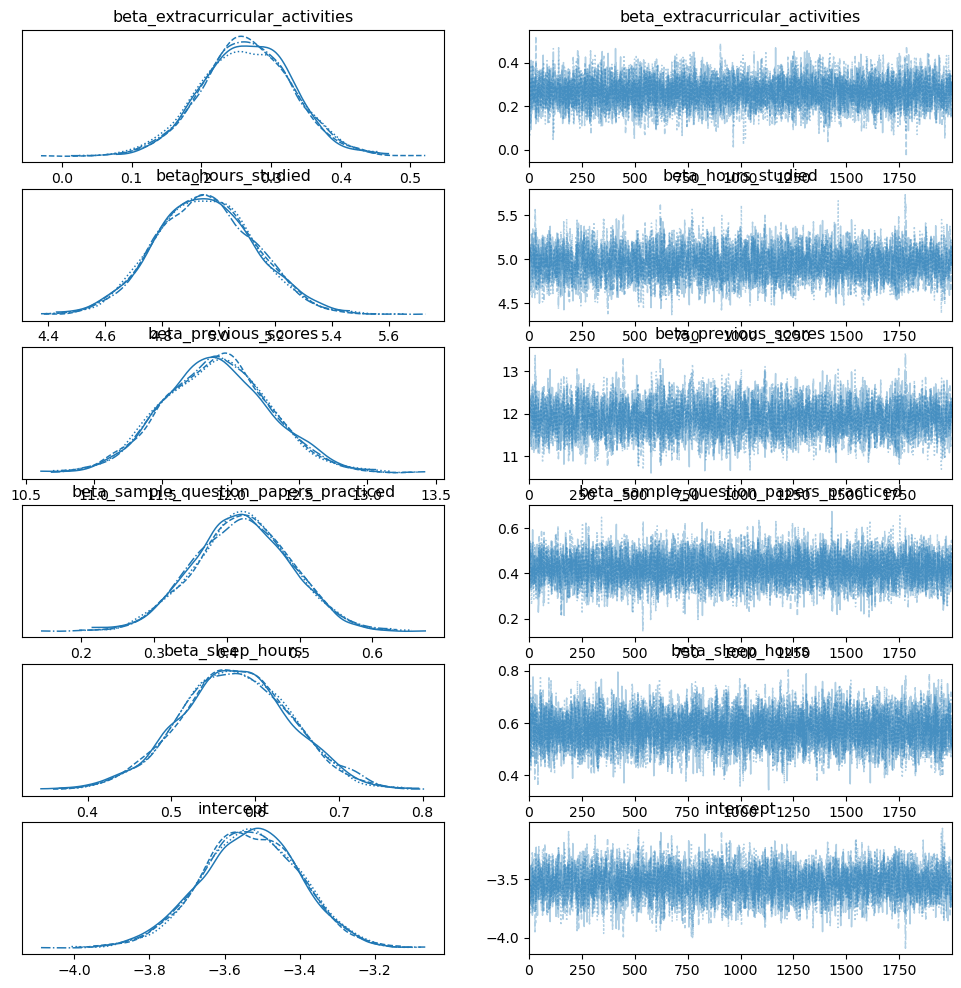

In [ ]:
# Visualize trace
az.plot_trace(trace, compact=True);
plt.show();

In [ ]:
# Summary of the posterior distributions
az.summary(trace, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  \
beta_extracurricular_activities         0.265  0.065     0.134      0.389   
beta_hours_studied                      4.954  0.174     4.602      5.278   
beta_previous_scores                   11.896  0.385    11.154     12.660   
beta_sample_question_papers_practiced   0.421  0.066     0.292      0.549   
beta_sleep_hours                        0.576  0.066     0.443      0.702   
intercept                              -3.532  0.132    -3.792     -3.275   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_extracurricular_activities            0.001    0.001    6778.0    4705.0   
beta_hours_studied                         0.003    0.002    3685.0    4128.0   
beta_previous_scores                       0.006    0.005    3589.0    3697.0   
beta_sample_question_papers_practiced      0.001    0.001    6031.0    5076.0   
beta_sleep_hours                           0.001    0.001    6400.0    4887.0   
intercept                                  0.002    0.002    3801.0    3752.0   

                                       r_hat  
beta_extracurricular_activities          1.0  
beta_hours_studied                       1.0  
beta_previous_scores                     1.0  
beta_sample_question_papers_practiced    1.0  
beta_sleep_hours                         1.0  
intercept                                1.0

In [58]:
# Posterior predictive checks
ppc = pm.sample_posterior_predictive(trace, model=logistic_model)

Sampling: [pass_fail]


Output()

KeyError: 'y_log'

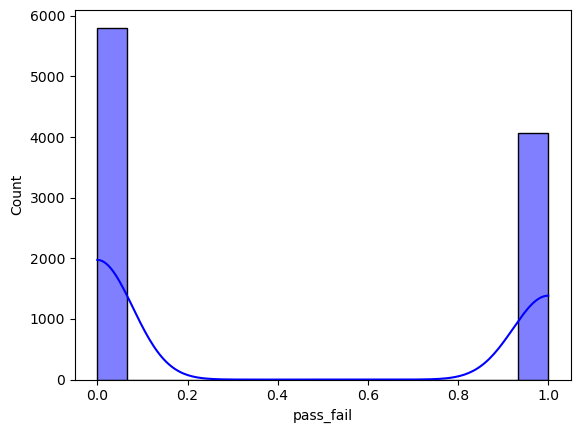

In [60]:
# Compare observed data to simulated posterior data
sns.histplot(y_log, color='blue', label='Observed', kde=True)
sns.histplot(ppc['y_log'].mean(axis=0), color='orange', label='Posterior Predictive', kde=True)
plt.legend()
plt.show()

array([[<Axes: ylabel='beta_extracurricular_activities'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_hours_studied'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_previous_scores'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_sample_question_papers_practiced'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_sleep_hours'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: xlabel='beta_extracurricular_activities', ylabel='intercept'>,
        <Axes: xlabel='beta_hours_studied'>,
        <Axes: xlabel='beta_previous_scores'>,
        <Axes: xlabel='beta_sample_question_papers_practiced'>,
        <Axes: xlabel='beta_sleep_hours'>, <Axes: xlabel='intercept'>]],
      dtype=object)

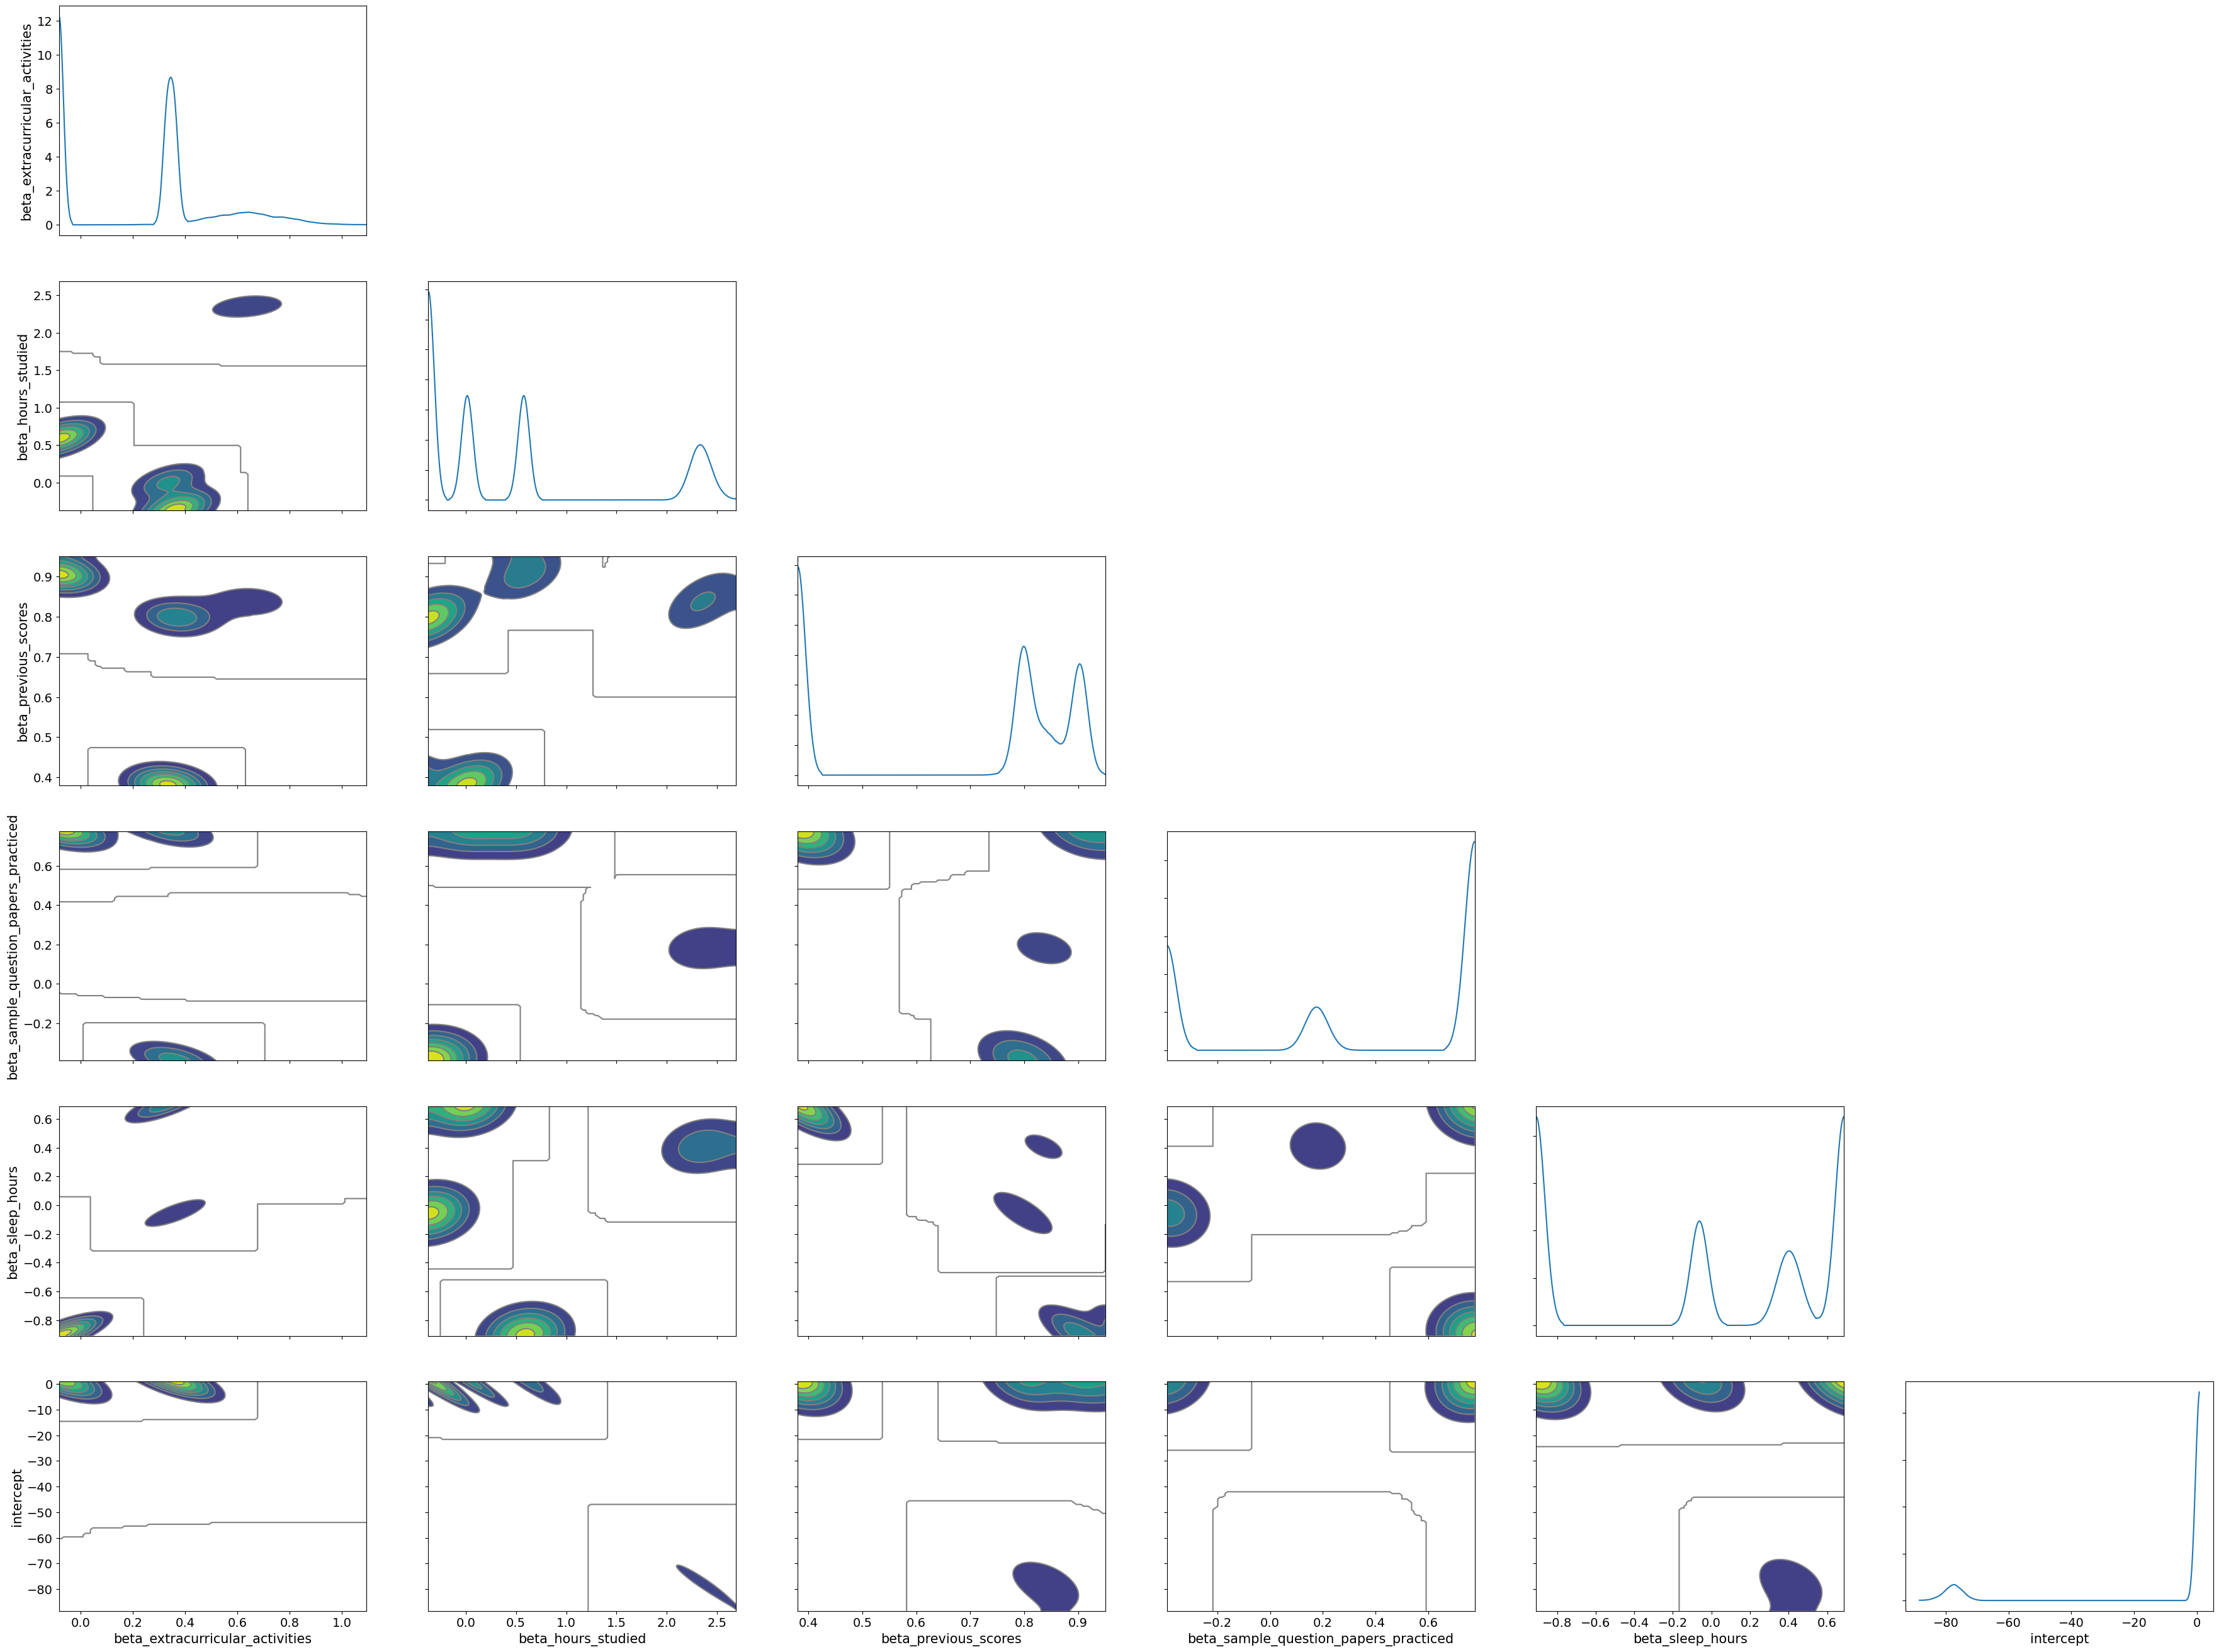

In [61]:
# Pair Plot
az.plot_pair(trace, kind="kde", marginals=True)

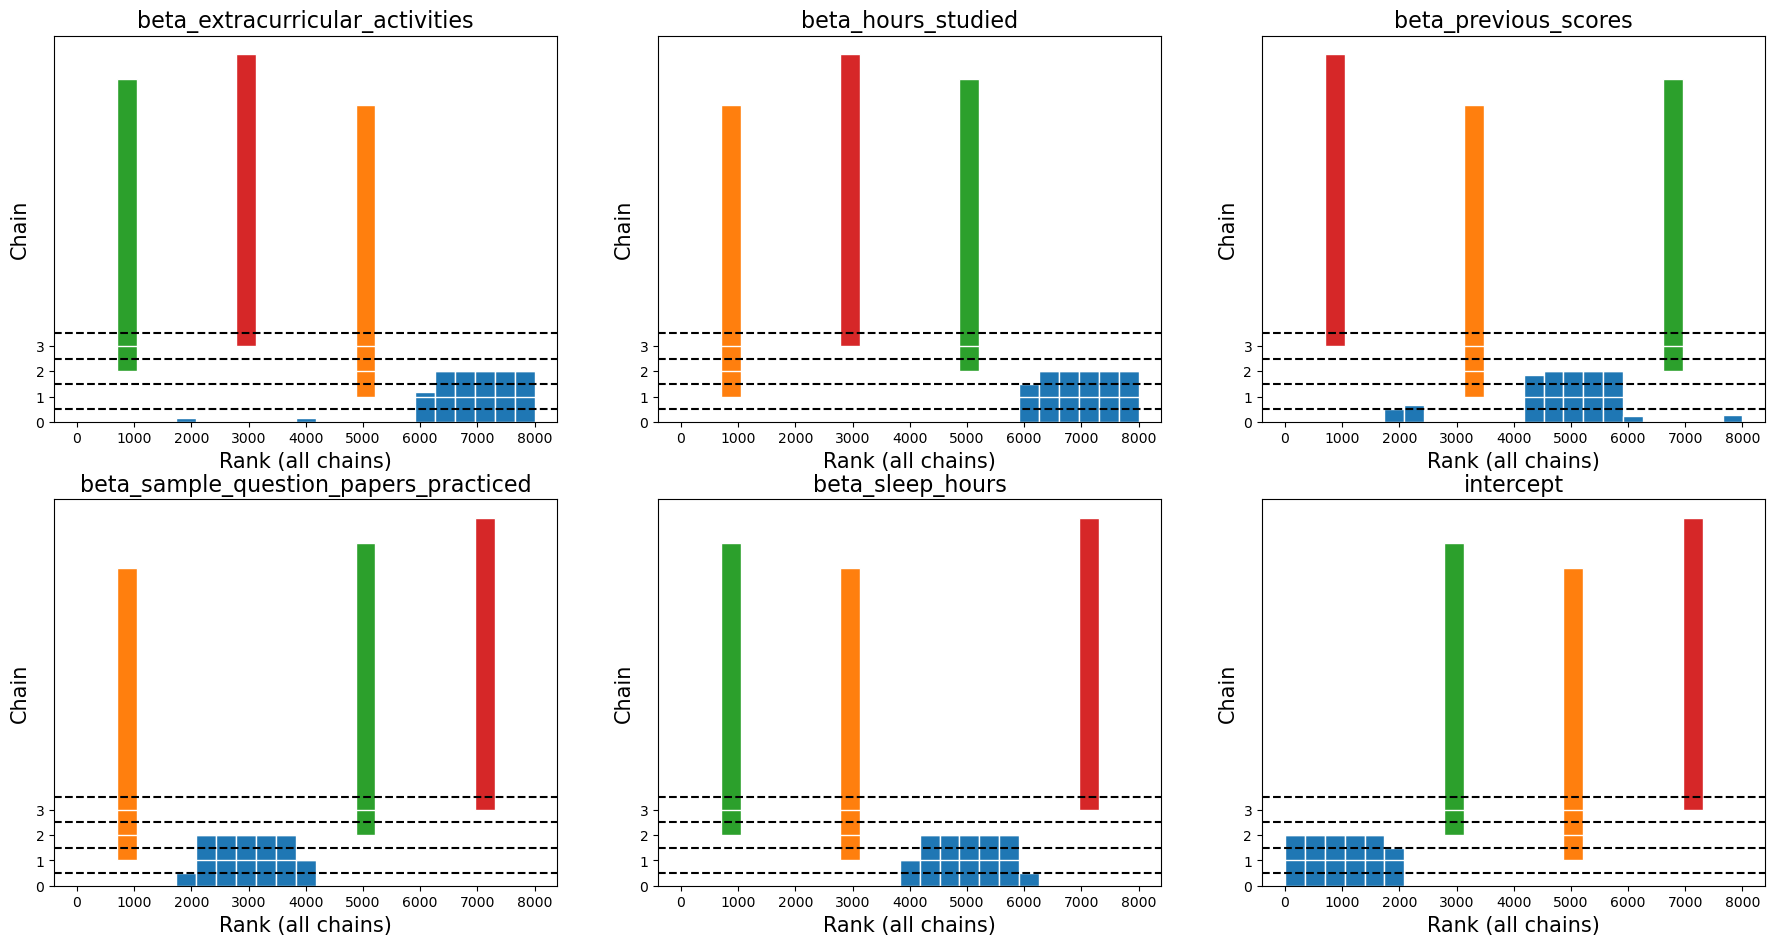

In [ ]:
# Rank Plot
az.plot_rank(trace)
plt.show()

In [63]:
# Posterior Interval Plot
az.plot_forest(trace, credible_interval=0.95)

TypeError: plot_forest() got an unexpected keyword argument 'credible_interval'

In [64]:
# Leave One Out Plot
loo = az.loo(trace, model=logistic_model)
az.plot_loo_pit(loo)
plt.show()

TypeError: loo() got an unexpected keyword argument 'model'

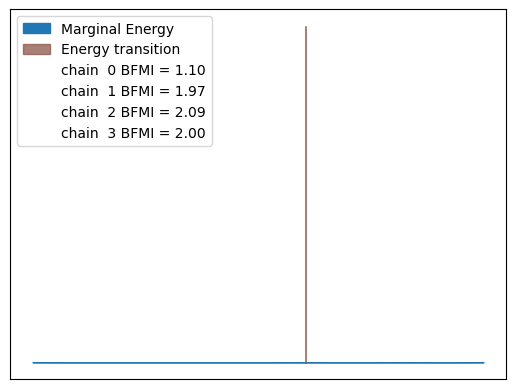

In [65]:
# Engery Plot
az.plot_energy(trace)
plt.show()

In [66]:
# Cumulative Distribution Function Plot
az.plot_cdf(trace)
plt.show()

AttributeError: module 'arviz' has no attribute 'plot_cdf'

In [67]:
# Correlation Matrix of Parameters
az.plot_corr(trace)
plt.show()

AttributeError: module 'arviz' has no attribute 'plot_corr'

In [69]:
X.head()

Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               99                           1            9   
1              4               82                           0            4   
2              8               51                           1            7   
3              5               52                           1            5   
4              7               75                           0            8   

   Sample Question Papers Practiced  
0                                 1  
1                                 2  
2                                 2  
3                                 2  
4                                 5

In [71]:
# Define the predictors (including setting sleep_hours to 8)
# Set other variables to their mean or median (you can adjust based on the actual dataset)
predictor_data = {
    "hours_studied": np.mean(X_shared[:, 0]),  # Set hours_studied to its mean or a specific value
    "previous_scores": np.mean(X_shared[:, 1]),  # Set previous_scores to its mean
    "extracurricular_activities": np.mean(X_shared[:, 2]),  # Set extracurricular activities to mean
    "sleep_hours": 8,  # Sleep set to 8 hours or more
    "sample_question_papers_practiced": np.mean(X_shared[:, 4])  # Set to mean or specific value
}

# Create a DataFrame with the repeated rows of predictor data
predictor_df = pd.DataFrame([predictor_data])

In [ ]:
# Sample posterior predictive
posterior_preds = pm.sample_posterior_predictive(trace, 
                                                 model=logistic_model, 
                                                 var_names=["pass_fail"], 
                                                 predictions=True)
                                                # , data={"X_shared": predictor_df.values})

Sampling: [pass_fail]


Output()

In [77]:
posterior_preds

Inference data with groups:
	> predictions

In [80]:
# Calculate the mean probability of passing
predicted_probs = posterior_preds['pass_fail_dim_2']
print("Mean Probability of Passing for Students with ≥8 Hours of Sleep:", predicted_probs)

KeyError: 'pass_fail_dim_2'

<br>

***

<Br>

## Hierarchical Model

- Model: Predicting continuous target (with parent income categories)
- Dataset: Student Performance Dataset

In [ ]:
df = pd.read_csv('./student_performance_data/Student_performance.csv')
le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
0    5052
1    4948
Name: count, dtype: int64

In [99]:
# Assuming you already have the student dataset, let's simulate 'parent_income'
n_students = len(df)  # df is your student dataset

# Simulate a continuous income variable
np.random.seed(42)  # For reproducibility
df['parent_income'] = np.random.uniform(1000, 100000, size=n_students)

# Split into 3 groups: Low Income, Middle Class, Wealthy
income_thresholds = np.percentile(df['parent_income'], [33, 66])

def income_group(income):
    if income <= income_thresholds[0]:
        return 'low_income'
    elif income <= income_thresholds[1]:
        return 'middle_class'
    else:
        return 'wealthy'

df['income_group'] = df['parent_income'].apply(income_group)

# Now you have a categorical variable 'income_group' for the hierarchy
print(df[['parent_income', 'income_group']].head())

   parent_income  income_group
0   38079.471766  middle_class
1   95120.716335       wealthy
2   73467.400239       wealthy
3   60267.189936  middle_class
4   16445.845404    low_income


In [100]:
groups = pd.Categorical(df['income_group']).codes  # Convert income groups to numeric

In [ ]:
# PyMC Hierarchical Model
with pm.Model() as hierarchical_model:
    
    # Hyperpriors for group-level intercepts and slopes
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)  # Overall intercept
    sigma_alpha = pm.HalfNormal('sigma_alpha', 5)     # Variability in intercepts
    
    mu_beta_hrs = pm.Normal('mu_beta_hrs', mu=0, sigma=10)  # Overall slope for 'Hours Studied'
    mu_beta_prev_scores = pm.Normal('mu_beta_prev_scores', mu=0, sigma=10)  # Overall slope for 'Previous Scores'
    mu_beta_extracurricular_activities = pm.Normal('mu_beta_extracurricular_activities', mu=0, sigma=10)  # Overall slope for 'Extracurricular Activities'
    mu_beta_sleep_hours = pm.Normal('mu_beta_sleep_hours', mu=0, sigma=10)  # Overall slope for 'Sleep Hours'
    mu_beta_sample_question_papers_practiced = pm.Normal('mu_beta_sample_question_papers_practiced', mu=0, sigma=10)  # Overall slope for 'Sample Question Papers Practiced'
    
    sigma_beta = pm.HalfNormal('sigma_beta', 5)  # Variability in slopes
    
    # Group-level intercepts and slopes
    alpha_group = pm.Normal('alpha_group', mu=mu_alpha, sigma=sigma_alpha, shape=len(np.unique(groups)))
    
    # Slopes for each group
    beta_hours_studied = pm.Normal('beta_hours_studied', mu=mu_beta_hrs, sigma=sigma_beta, shape=len(np.unique(groups)))
    beta_previous_scores = pm.Normal('beta_previous_scores', mu=mu_beta_prev_scores, sigma=sigma_beta, shape=len(np.unique(groups)))
    beta_extracurricular_activities = pm.Normal('beta_extracurricular_activities', mu=mu_beta_extracurricular_activities, sigma=sigma_beta, shape=len(np.unique(groups)))
    beta_sleep_hours = pm.Normal('beta_sleep_hours', mu=mu_beta_sleep_hours, sigma=sigma_beta, shape=len(np.unique(groups)))
    beta_sample_question_papers_practiced = pm.Normal('beta_sample_question_papers_practiced', mu=mu_beta_sample_question_papers_practiced, sigma=sigma_beta, shape=len(np.unique(groups)))
    
    # Group-specific intercept and slopes
    alpha = alpha_group[groups]  # Intercept depends on group (income)
    beta_hours = beta_hours_studied[groups]  # Slope for 'Hours Studied' depends on group
    beta_prev_scores = beta_previous_scores[groups]  # Slope for 'Previous Scores' depends on group
    beta_extra_activities = beta_extracurricular_activities[groups]  # Slope for 'Extracurricular Activities' depends on group
    beta_sleep = beta_sleep_hours[groups]  # Slope for 'Sleep Hours' depends on group
    beta_sample_qp = beta_sample_question_papers_practiced[groups]  # Slope for 'Sample Question Papers Practiced' depends on group
    
    # Linear regression model using normalized predictors
    mu = (alpha # intercept
        + beta_hours_studied * X['Hours Studied']
        + beta_previous_scores * X['Previous Scores']
        + beta_extracurricular_activities * X['Extracurricular Activities']
        + beta_sleep_hours * X['Sleep Hours']
        + beta_sample_question_papers_practiced * X['Sample Question Papers Practiced'])

    # Likelihood (Gaussian for simplicity, but could be Bernoulli for binary outcomes)
    sigma = pm.HalfNormal('sigma', sigma=1)
    likelihood = pm.Normal('performance_index', mu=mu, sigma=sigma, observed=y_lin)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, chains=4, return_inferencedata=True)

mean     sd  hdi_3%  hdi_97%  \
beta_extracurricular_activities         0.616  0.041   0.535    0.691   
beta_hours_studied                      2.853  0.008   2.837    2.867   
beta_previous_scores                    1.018  0.001   1.016    1.020   
beta_sample_question_papers_practiced   0.194  0.007   0.180    0.207   
beta_sleep_hours                        0.480  0.012   0.457    0.503   
intercept                             -34.064  0.130 -34.312  -33.822   
sigma                                   2.044  0.014   2.018    2.071   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_extracurricular_activities            0.000    0.000    8330.0    5960.0   
beta_hours_studied                         0.000    0.000    7230.0    5582.0   
beta_previous_scores                       0.000    0.000    6011.0    5139.0   
beta_sample_question_papers_practiced      0.000    0.000    7821.0    5123.0   
beta_sleep_hours                           0.000    0.000    5707.0    5394.0   
intercept                                  0.002    0.001    4387.0    4565.0   
sigma                                      0.000    0.000    6772.0    5568.0   

                                       r_hat  
beta_extracurricular_activities          1.0  
beta_hours_studied                       1.0  
beta_previous_scores                     1.0  
beta_sample_question_papers_practiced    1.0  
beta_sleep_hours                         1.0  
intercept                                1.0  
sigma                                    1.0

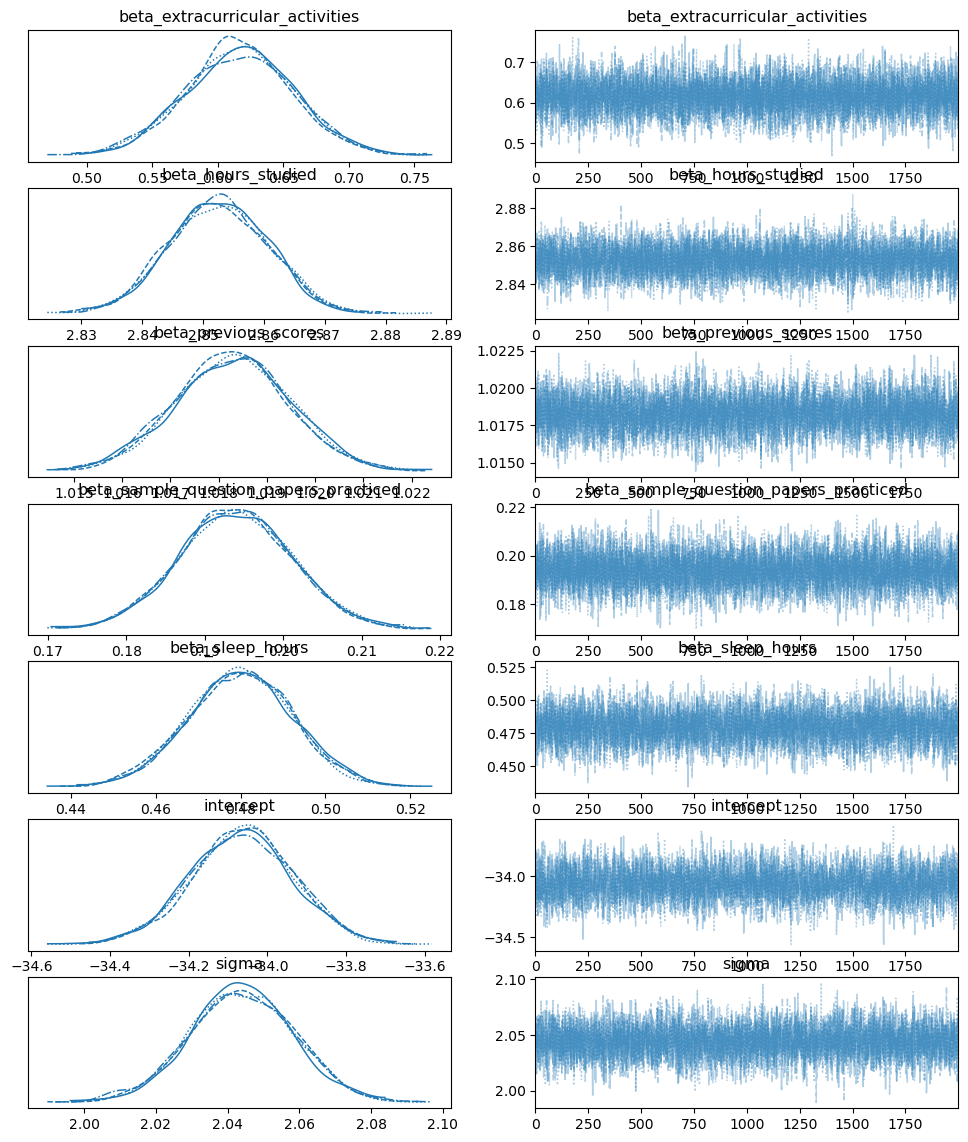

In [101]:
# Summarize and visualize the posterior
az.plot_trace(trace)
az.summary(trace)

In [102]:
# Extract posterior samples
posterior_alpha_group = trace.posterior['alpha_group'].mean(dim=["chain", "draw"]).values
posterior_beta_hours_studied = trace.posterior['beta_hours_studied'].mean(dim=["chain", "draw"]).values
posterior_beta_previous_scores = trace.posterior['beta_previous_scores'].mean(dim=["chain", "draw"]).values

# Plotting the group-specific intercepts (baseline pass/fail likelihood)
plt.bar(['Low Income', 'Middle Class', 'Wealthy'], posterior_alpha_group)
plt.title("Group-Specific Intercepts (Baseline pass/fail likelihood)")
plt.ylabel("Intercept")
plt.show()

# You can also create similar plots for the slopes
plt.bar(['Low Income', 'Middle Class', 'Wealthy'], posterior_beta_hours_studied)
plt.title("Group-Specific Slopes for Hours Studied")
plt.ylabel("Slope")
plt.show()

plt.bar(['Low Income', 'Middle Class', 'Wealthy'], posterior_beta_previous_scores)
plt.title("Group-Specific Slopes for Previous Scores")
plt.ylabel("Slope")
plt.show()

KeyError: "No variable named 'alpha_group'. Variables on the dataset include ['chain', 'draw', 'beta_extracurricular_activities', 'beta_hours_studied', 'beta_previous_scores', 'beta_sample_question_papers_practiced', 'beta_sleep_hours', 'intercept', 'sigma']"

<br>

***

<Br>

## Mixture Model

- Model: Predicting continuous target (don't know the groupings, but know some exist)
- Dataset: Student Performance Dataset

In [ ]:
df = pd.read_csv('./student_performance_data/Student_performance.csv')
le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
0    5052
1    4948
Name: count, dtype: int64

<br>

***

<Br>

## Bayesian Additive Trees Model

- Model: Predicting continuous target (Customer Revenue)
- Dataset: Fake Shopify Dataset

<br>

***

<Br>

## Gaussian Process

- Model: Predicting continuous target (Performance Index in this case)
- Dataset: Student Performance Dataset

In [26]:
# Normalize the input features for better GP performance
X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_norm = X_norm.values
y_lin = y_lin.values

In [ ]:
%%time
with pm.Model() as gp_model:

    # Define priors for the linear part
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coefficients = pm.Normal('coefficients', mu=0, sigma=10, shape=X.shape[1]) # all coefficients here
    
    # Linear regression component
    linear_part = intercept + pm.math.dot(X, coefficients)
    
    # Gaussian Process: Covariance kernel (Radial Basis Function - RBF kernel)
    l = pm.Gamma('l', alpha=2, beta=1)  # Length scale
    eta = pm.HalfCauchy('eta', beta=5)  # Signal variance

    # Covariance function (RBF kernel)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=X.shape[1], ls=l)
    
    # Gaussian Process prior
    gp = pm.gp.Marginal(cov_func=cov)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)  # Observation noise
    y_ = gp.marginal_likelihood('y_', X=X_norm, y=y_lin, sigma=sigma)
    
    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
%%time
with pm.Model() as model:
    # Mean and Covariance functions
    mean_func = pm.gp.mean.Constant(0)
    cov_func = pm.gp.cov.ExpQuad(input_dim=X.shape[1], ls=1.0)

    # Gaussian Process model
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    
    # Observation noise (sigma)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Marginal likelihood
    y_obs = gp.marginal_likelihood("y_obs", X=X_norm, y=y_lin, sigma=sigma)
    
    # Sampling from the posterior
    trace = pm.sample(500, return_inferencedata=True)

<br>

***

<Br>

## Do-Calculus

- Model: Causes of student performance
- Dataset: Student Performance Dataset

## MMM

- Model: Marketing Mix Modeling (MMM) is a powerful tool for understanding how different marketing channels contribute to outcomes like sales or conversions. 
- Dataset: Fake Company Marketing Channels

In [22]:
# Create Fake Dataset

# Random seed for reproducibility
np.random.seed(42)

n_weeks = 100
data = pd.DataFrame({
    "week": np.arange(n_weeks),
    "radio": np.random.uniform(0, 500, n_weeks),
    "social": np.random.uniform(0, 1000, n_weeks),
    "tv": np.random.uniform(0, 800, n_weeks),
    "paid_search": np.random.uniform(0, 600, n_weeks),
    "crm": np.random.uniform(0, 300, n_weeks)
})

# Simulate base sales
data["base_sales"] = 1000 + np.random.normal(0, 10, n_weeks)

# Ensure true_params is a DataFrame or Series
true_params = pd.DataFrame({
    "radio": [0.1] * n_weeks,
    "social": [0.2] * n_weeks,
    "tv": [0.3] * n_weeks,
    "paid_search": [0.4] * n_weeks,
    "crm": [0.5] * n_weeks
})

# Convert true_params["crm"] to a Series if it's not already
true_params["crm"] = pd.Series(true_params["crm"])

# Adding response variable with noise
data["sales"] = (
    data["base_sales"]
    + true_params["radio"] * np.log(data["radio"] + 1)
    + true_params["social"] * (data["social"] / (1 + data["social"]))
    + true_params["tv"] * data["tv"] * 0.8  # Placeholder for adstock
    + true_params["paid_search"] * data["paid_search"]
    + true_params["crm"].shift(1).fillna(0) * data["crm"]
    + np.random.normal(0, 50, n_weeks)  # Add noise
)

data.head()


week       radio      social          tv  paid_search         crm  \
0     0  187.270059   31.429186  513.625317    31.009033   30.937161   
1     1  475.357153  636.410411   67.311972   318.812779  270.765872   
2     2  365.996971  314.355981  129.302971   324.381073  151.575712   
3     3  299.329242  508.570691  718.843351   382.457941  247.937240   
4     4   78.009320  907.566474  485.143248   435.654800   96.014880   

    base_sales        sales  
0  1003.417560  1107.480225  
1  1018.761708  1244.563532  
2  1009.504238  1331.224219  
3   994.230963  1488.557247  
4   991.015853  1329.957697

In [24]:
# Define adstock transformation
def adstock_transform(x, rate=0.8):
    adstock = np.zeros_like(x)
    adstock[0] = x[0]
    for i in range(1, len(x)):
        adstock[i] = x[i] + rate * adstock[i - 1]
    return adstock

# Hill saturation transformation
def hill_transform(x, alpha, beta):
    return alpha * x / (beta + x)

# Apply transformations to the data
data["tv_adstock"] = adstock_transform(data["tv"].values)
data["social_hill"] = hill_transform(data["social"].values, alpha=1, beta=100)

data.head()

week       radio      social          tv  paid_search         crm  \
0     0  187.270059   31.429186  513.625317    31.009033   30.937161   
1     1  475.357153  636.410411   67.311972   318.812779  270.765872   
2     2  365.996971  314.355981  129.302971   324.381073  151.575712   
3     3  299.329242  508.570691  718.843351   382.457941  247.937240   
4     4   78.009320  907.566474  485.143248   435.654800   96.014880   

    base_sales        sales   tv_adstock  social_hill  
0  1003.417560  1107.480225   513.625317     0.239134  
1  1018.761708  1244.563532   478.212226     0.864206  
2  1009.504238  1331.224219   511.872752     0.758662  
3   994.230963  1488.557247  1128.341552     0.835681  
4   991.015853  1329.957697  1387.816489     0.900751

In [26]:
%%time

# PYMC model for MMM
with pm.Model() as mmm_model:

    # Priors for the coefficients
    radio_coeff = pm.Normal("radio_coeff", mu=0, sigma=1)
    social_coeff = pm.Normal("social_coeff", mu=0, sigma=1)
    tv_coeff = pm.Normal("tv_coeff", mu=0, sigma=1)
    paid_search_coeff = pm.Normal("paid_search_coeff", mu=0, sigma=1)
    crm_coeff = pm.Normal("crm_coeff", mu=0, sigma=1)
    
    # Intercept & noise
    intercept = pm.Normal("intercept", mu=1000, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=50)

    # Expected sales wtih transformations applied
    expected_sales = (
        intercept
        + radio_coeff * at.log(data["radio"].values + 1)
        + social_coeff * data["social_hill"]
        + tv_coeff * data["tv_adstock"]
        + paid_search_coeff * data["paid_search"].values
        + crm_coeff * data["crm"].shift(1).fillna(0)
    )

    # Likelihood
    sales_obs = pm.Normal("sales_obs", mu=expected_sales, sigma=sigma, observed=data["sales"].values)

    # Sample
    trace = pm.sample(1000, tune=1000, target_accpet=0.9)


ValueError: Invalid key found in step_kwargs: {'target_accpet'}. Keys must be step names and values valid kwargs for that stepper. Did you mean {"nuts": {"target_accpet": ...}}?

In [5]:
# Summarize the results
pm.summary(trace)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta_radio      0.340   0.059     0.233     0.455      0.001    0.001   
beta_social     0.387   0.042     0.308     0.466      0.001    0.001   
beta_tv         0.519   0.034     0.456     0.581      0.001    0.000   
intercept    2976.655  46.599  2889.512  3063.454      1.040    0.735   
sigma          47.474   4.810    38.870    56.619      0.081    0.058   

             ess_bulk  ess_tail  r_hat  
beta_radio     2547.0    2532.0   1.00  
beta_social    2802.0    2309.0   1.00  
beta_tv        2422.0    2269.0   1.01  
intercept      1998.0    2305.0   1.00  
sigma          3571.0    3067.0   1.00

<br>

## CLV

- Model: Customer Lifetime Values (CLV)
- Dataset: Fake Customer Lifetime Value Dataset

In [31]:
# Parameters for dataset
num_customers = 200  # Number of unique customers
max_days = 365       # Time period in days
np.random.seed(42)

# Generate customer IDs
customer_ids = np.arange(1, num_customers + 1)

# Simulate transaction data
data = {
    "customer_id": [],
    "transaction_date": [],
    "transaction_amount": [],
}

# Create transactions for each customer
for customer in customer_ids:
    num_transactions = np.random.poisson(5)  # Average of 5 transactions per customer
    transaction_dates = [datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, max_days)) for _ in range(num_transactions)]
    transaction_amounts = np.round(np.random.uniform(20, 200, num_transactions), 2)  # Random amount between $20 and $200

    # Append each transaction to the data dictionary
    for date, amount in zip(transaction_dates, transaction_amounts):
        data["customer_id"].append(customer)
        data["transaction_date"].append(date)
        data["transaction_amount"].append(amount)

# Convert to a DataFrame
clv_data = pd.DataFrame(data)

# Preview the dataset
print(clv_data.head())

   customer_id transaction_date  transaction_amount
0            1       2023-11-27              137.16
1            1       2023-03-29               30.15
2            1       2023-04-10              149.96
3            1       2023-12-26              188.94
4            1       2023-06-01               20.14


In [32]:
# Preprocess data for model
# Summarize each customer's total spend and purchase frequency
customer_summary = clv_data.groupby("customer_id").agg(
    frequency=("transaction_date", "count"),
    recency=("transaction_date", lambda x: (x.max() - x.min()).days),
    monetary_value=("transaction_amount", "mean")
).reset_index()

# Filter out customers with no repeat purchases for simplicity in this example
customer_summary = customer_summary[customer_summary["frequency"] > 1]

# Convert columns to arrays for PyMC
frequency = customer_summary["frequency"].values
recency = customer_summary["recency"].values
monetary_value = customer_summary["monetary_value"].values

In [ ]:
# Define the PyMC CLV model
with pm.Model() as clv_model:
    # Priors for purchase frequency
    lambda_ = pm.Exponential("lambda", lam=1.0)  # Purchase frequency rate
    frequency_obs = pm.Poisson("frequency_obs", mu=lambda_, observed=frequency)
    
    # Priors for recency effect
    alpha = pm.Exponential("alpha", lam=0.5)  # Decay rate for recency
    recency_obs = pm.Exponential("recency_obs", lam=alpha, observed=recency)

    # Priors for monetary value of purchases
    mu_amount = pm.Normal("mu_amount", mu=50, sigma=20)
    sigma_amount = pm.HalfNormal("sigma_amount", sigma=25)
    monetary_obs = pm.LogNormal("monetary_obs", mu=mu_amount, sigma=sigma_amount, observed=monetary_value)

    # Sample from the model
    trace = pm.sample(1000, tune=500, return_inferencedata=True, random_seed=42)

In [ ]:
# Summarize and plot results
az.plot_trace(trace, var_names=["lambda", "alpha", "mu_amount", "sigma_amount"])
summary = az.summary(trace, var_names=["lambda", "alpha", "mu_amount", "sigma_amount"])
print(summary)

# Predicted mean CLV for the cohort
predicted_clv = summary.loc["mu_amount", "mean"] * summary.loc["lambda", "mean"]
print(f"Predicted average CLV: ${predicted_clv:.2f}")

## MTA

- Model: Multi-Touch Attributino (MTA) models typically require detailed data on customer journeys and interactions with various marketing channels before a conversion. 
- Dataset: Fake Customer Journey Data

In [27]:
# Set a random seed for reproducibility
np.random.seed(42)

# Parameters for simulation
n_customers = 5000  # Number of customer journeys
channels = ["social", "email", "search", "display", "direct"]
conversion_rate = 0.3  # Baseline probability of conversion
channel_probabilities = {
    "social": 0.7,
    "email": 0.5,
    "search": 0.8,
    "display": 0.6,
    "direct": 0.9
}
interaction_strengths = {
    "social": 1.1,
    "email": 1.05,
    "search": 1.3,
    "display": 1.1,
    "direct": 1.5
}

# Simulate dataset
data = []

for customer_id in range(n_customers):
    journey_length = np.random.randint(1, 6)  # Number of interactions per journey
    interactions = np.random.choice(channels, size=journey_length, p=[0.2, 0.2, 0.2, 0.2, 0.2])
    
    # Calculate a weighted probability of conversion
    base_conversion_prob = conversion_rate
    channel_impact = sum(interaction_strengths[channel] for channel in interactions)
    adjusted_conversion_prob = base_conversion_prob * (channel_impact / journey_length)

    # Simulate conversion based on adjusted probability
    conversion = np.random.binomial(1, min(adjusted_conversion_prob, 1.0))

    # Record each interaction
    for interaction in interactions:
        data.append({
            "customer_id": customer_id,
            "channel": interaction,
            "conversion": conversion
        })

# Convert to DataFrame
mta_data = pd.DataFrame(data)

# Preview the dataset
mta_data.head(10)

customer_id  channel  conversion
0            0   direct           0
1            0  display           0
2            0   search           0
3            0   social           0
4            1   search           0
5            1    email           0
6            1   social           0
7            2   direct           0
8            2   direct           0
9            2    email           0

In [29]:
# Encode channels as one-hot variables
mta_data = pd.get_dummies(mta_data, columns=["channel"], drop_first=True)

# Define the formula for the model - logistic regression with one-hot encoded channels
formula = "conversion ~ channel_display + channel_direct + channel_email + channel_search + channel_social"

# Use patsy to create design matrices
y, X = patsy.dmatrices(formula, mta_data, return_type='dataframe')

PatsyError: Error evaluating factor: NameError: name 'channel_direct' is not defined
    conversion ~ channel_display + channel_direct + channel_email + channel_search + channel_social
                                   ^^^^^^^^^^^^^^

In [ ]:
# Define the PYMC Model
with pm.Model() as mta_model:
    # Intercept for the base converion probability
    intercept = pm.Normal("intercept", mu=0, sigma=2)

    # Coefficients for each channel with a normal prior
    channel_coefs = pm.Normal("channel_coefs", mu=0, sigma=2, shape=X.shape[1])

    # Logistic Regression with Saturation Effects
    # Transform channel weights to account for saturation using a sigmoid function